In [1]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import precision_score, recall_score




def preprocess_wine(file_path):
    data = pd.read_csv(file_path, sep=';')
    data['quality'] = data['quality'].apply(lambda x: 1 if x >= 7 else 0)
    X = data.drop(columns=['quality'])
    y = data['quality']
    return X, y

def preprocess_abalone(file_path):
    columns = ['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings']
    data = pd.read_csv(file_path, header=None, names=columns)
    data['Rings'] = data['Rings'].apply(lambda x: 1 if x >= 10 else 0)
    encoder = LabelEncoder()
    data['Sex'] = encoder.fit_transform(data['Sex'])
    X = data.drop(columns=['Rings'])
    y = data['Rings']
    return X, y

def preprocess_student(file_path):
    data = pd.read_csv(file_path, sep=';')
    data['G3'] = data['G3'].apply(lambda x: 1 if x >= 10 else 0)
    X = data.drop(columns=['G3'])
    y = data['G3']
    X = pd.get_dummies(X, drop_first=True)
    return X, y

def scale_data(X):
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean())
    scaler = StandardScaler()
    return scaler.fit_transform(X)


In [2]:
def train_and_evaluate_with_confusion(clf, param_grid, X, y, partitions, cv=5, trials=3):
    results = {}
    for partition in partitions:
        trial_results = []
        for trial in range(trials):
            random_state = np.random.randint(1, 1000)  
            train_size = partition
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

            grid_search = GridSearchCV(
                estimator=clf,
                param_grid=param_grid,
                cv=cv,
                scoring='accuracy',
                n_jobs=-1,
                return_train_score=True
            )
            grid_search.fit(X_train, y_train)

            best_model = grid_search.best_estimator_
            train_acc = accuracy_score(y_train, best_model.predict(X_train))
            validation_acc = grid_search.best_score_
            test_acc = accuracy_score(y_test, best_model.predict(X_test))


            y_pred = best_model.predict(X_test)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            confusion = confusion_matrix(y_test, y_pred)

            trial_results.append({
                "best_params": grid_search.best_params_,
                "train_accuracy": train_acc,
                "validation_accuracy": validation_acc,
                "test_accuracy": test_acc,
                "test_precision": precision,
                "test_recall": recall,
                "confusion_matrix": confusion,
                "cv_results": grid_search.cv_results_
            })
        
        average_train_accuracy = np.mean([trial['train_accuracy'] for trial in trial_results])
        average_validation_accuracy = np.mean([trial['validation_accuracy'] for trial in trial_results])
        average_test_accuracy = np.mean([trial['test_accuracy'] for trial in trial_results])
        
        results[f"{int(partition*100)}/{int((1-partition)*100)}"] = {
            "average_train_accuracy": average_train_accuracy,
            "average_validation_accuracy": average_validation_accuracy,
            "average_test_accuracy": average_test_accuracy,
            "all_trials": trial_results  
        }
    return results


def plot_results(results, title):
    partitions = list(results.keys())
    train_accuracies = [results[p]['average_train_accuracy'] for p in partitions]
    validation_accuracies = [results[p]['average_validation_accuracy'] for p in partitions]
    test_accuracies = [results[p]['average_test_accuracy'] for p in partitions]

    train_errors = [1 - acc for acc in train_accuracies]
    validation_errors = [1 - acc for acc in validation_accuracies]
    test_errors = [1 - acc for acc in test_accuracies]

    plt.figure(figsize=(12, 6))
    plt.plot(partitions, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(partitions, validation_accuracies, label='Validation Accuracy', marker='o')
    plt.plot(partitions, test_accuracies, label='Test Accuracy', marker='o')
    plt.plot(partitions, train_errors, label='Train Error', linestyle='--', marker='x')
    plt.plot(partitions, validation_errors, label='Validation Error', linestyle='--', marker='x')
    plt.plot(partitions, test_errors, label='Test Error', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel('Train/Test Split')
    plt.ylabel('Accuracy/Error')
    plt.legend()
    plt.grid()
    plt.show()

def plot_error_curves(cv_results, hyperparam, title):
    train_scores = 1 - cv_results['mean_train_score']  
    validation_scores = 1 - cv_results['mean_test_score'] 
    param_values = cv_results[f'param_{hyperparam}']

    plt.figure(figsize=(10, 6))
    plt.plot(param_values, train_scores, label='Training Error', marker='o')
    plt.plot(param_values, validation_scores, label='Validation Error', marker='o')
    plt.title(f"{title} ({hyperparam})")
    plt.xlabel(hyperparam)
    plt.ylabel('Classification Error')
    plt.legend()
    plt.grid()
    plt.show()

def plot_confusion_matrix(cm, title):
    dis = ConfusionMatrixDisplay(confusion_matrix=cm)
    dis.plot(cmap='Blues')
    plt.title(title)
    plt.show()





In [3]:
wine_file = "winequality-white.csv"
abalone_file = "abalone.data"
student_file = "student-mat.csv"

partitions = [0.8, 0.5, 0.2]
classifiers = {
    "Decision Tree": (
        DecisionTreeClassifier(), 
        {
            "max_depth": [5, 10, 15],
            "min_samples_split": [2, 5, 10]
        }
    ),
    "KNN": (
        KNeighborsClassifier(), 
        {
            "n_neighbors": [3, 5, 7, 9],  
            "weights": ["uniform", "distance"],  
            "p": [1, 2]  
        }
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42), 
        {
            "n_estimators": [50, 100, 150],  
            "max_depth": [10, 20, 30],  
            "min_samples_split": [2, 5, 10]  
        }
    )
}




========== Visualizing Wine Dataset ==========
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8      

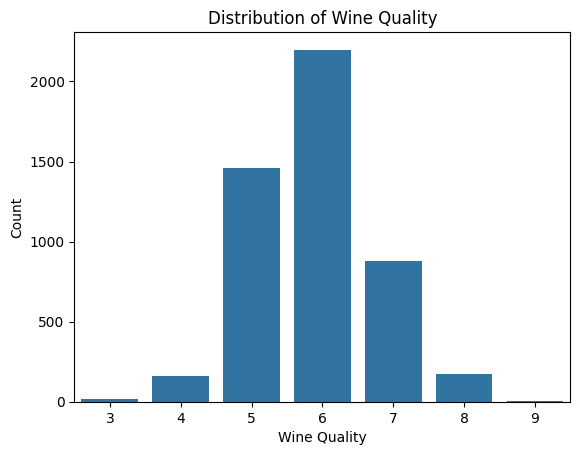

In [4]:
print("\n========== Visualizing Wine Dataset ==========")
wine_data = pd.read_csv(wine_file, sep=';')
print(wine_data.head())
sns.countplot(x='quality', data=wine_data)
plt.title("Distribution of Wine Quality")
plt.xlabel("Wine Quality")
plt.ylabel("Count")
plt.show()


========== Visualizing Abalone Dataset ==========
  Sex  Length  Diameter  Height  WholeWeight  ShuckedWeight  VisceraWeight  \
0   M   0.455     0.365   0.095       0.5140         0.2245         0.1010   
1   M   0.350     0.265   0.090       0.2255         0.0995         0.0485   
2   F   0.530     0.420   0.135       0.6770         0.2565         0.1415   
3   M   0.440     0.365   0.125       0.5160         0.2155         0.1140   
4   I   0.330     0.255   0.080       0.2050         0.0895         0.0395   

   ShellWeight  Rings  
0        0.150     15  
1        0.070      7  
2        0.210      9  
3        0.155     10  
4        0.055      7  


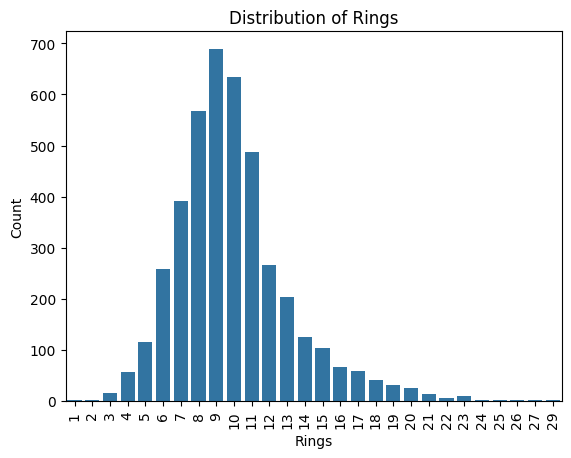

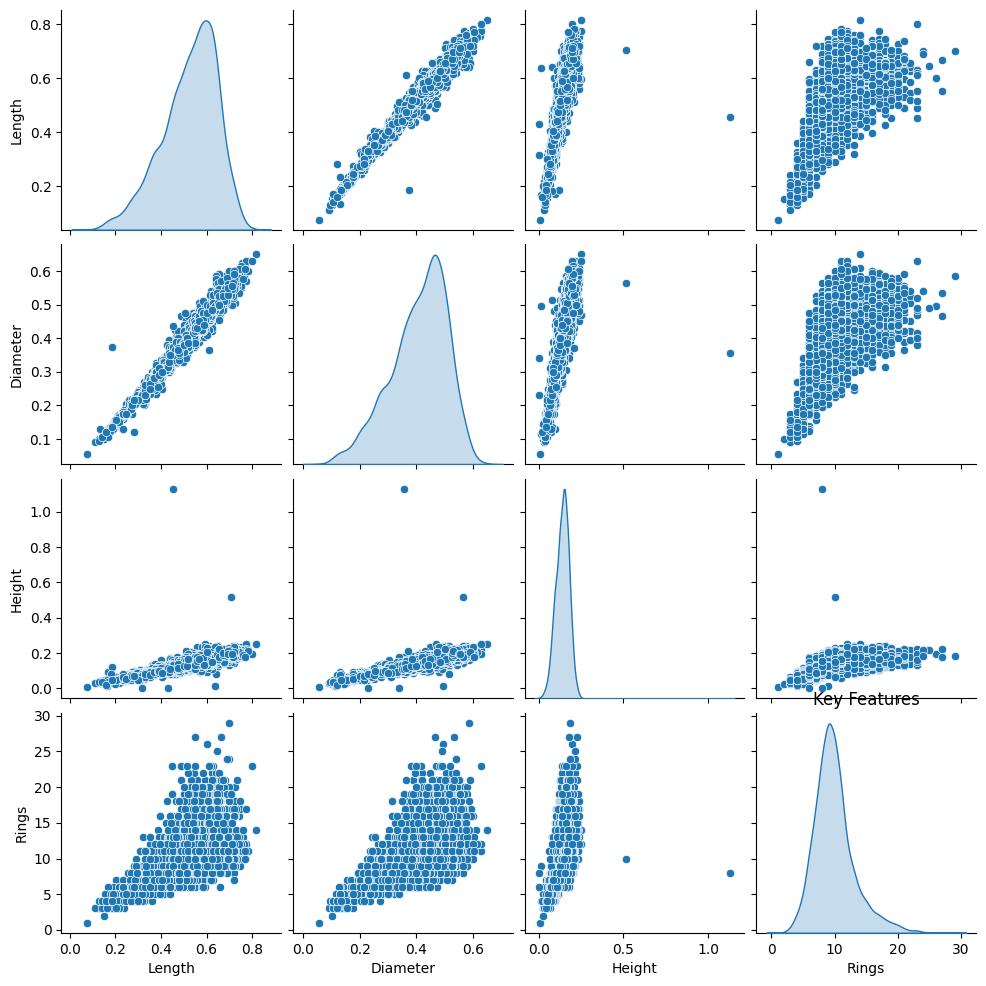

In [5]:
print("\n========== Visualizing Abalone Dataset ==========")
abalone_data = pd.read_csv(abalone_file, header=None, names=[
    'Sex', 'Length', 'Diameter', 'Height', 'WholeWeight',
    'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings'
])
print(abalone_data.head())

sns.countplot(x='Rings', data=abalone_data)
plt.title("Distribution of Rings")
plt.xlabel("Rings")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

sns.pairplot(abalone_data[['Length', 'Diameter', 'Height', 'Rings']], diag_kind='kde')
plt.title("Key Features")
plt.show()


========== Visualizing Student Dataset ==========
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]


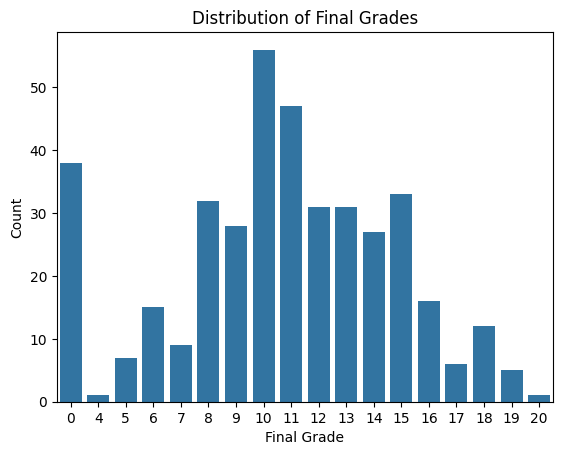

In [6]:
print("\n========== Visualizing Student Dataset ==========")
student_data = pd.read_csv(student_file, sep=';')
print(student_data.head())

sns.countplot(x='G3', data=student_data)
plt.title("Distribution of Final Grades")
plt.xlabel("Final Grade")
plt.ylabel("Count")
plt.show()


========== Running Models on Wine Dataset ==========

Running Decision Tree on Wine dataset...

Results for Decision Tree on Wine (80/19 Split):
  Average Train Accuracy: 0.9748
  Average Train Error: 0.0252
  Average Validation Accuracy: 0.8127
  Average Validation Error: 0.1873
  Average Test Accuracy: 0.8248
  Average Test Error: 0.1752
  Test Precision: 0.5546
  Test Recall: 0.6256
  Test Precision: 0.5663
  Test Recall: 0.5606
  Test Precision: 0.5743
  Test Recall: 0.5949
  Average Test Precision: 0.5651
  Average Test Recall: 0.5937


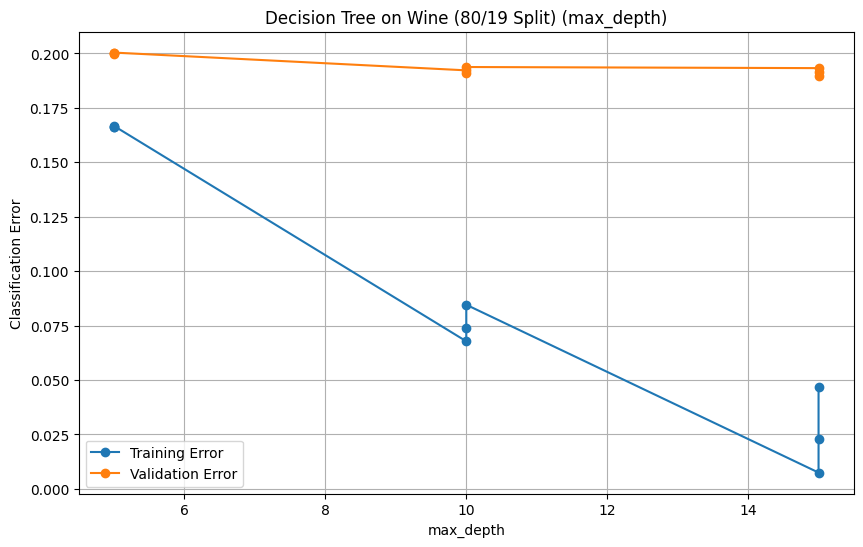

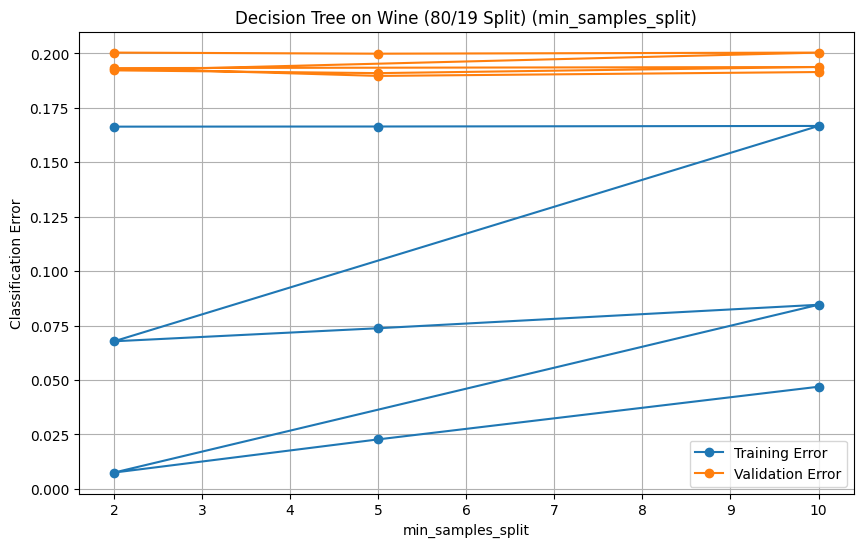

  Aggregated Confusion Matrix:
[[2071  273]
 [ 242  354]]



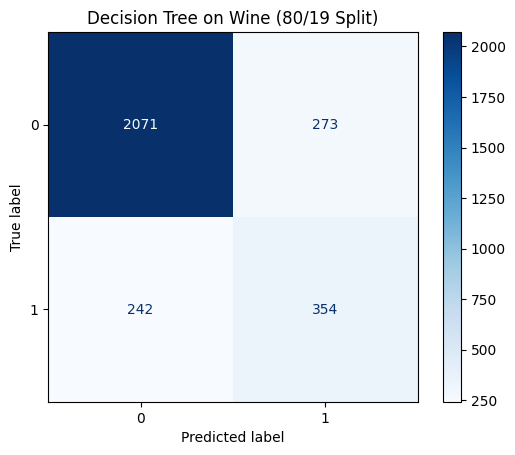

Results for Decision Tree on Wine (50/50 Split):
  Average Train Accuracy: 0.9138
  Average Train Error: 0.0862
  Average Validation Accuracy: 0.8100
  Average Validation Error: 0.1900
  Average Test Accuracy: 0.8006
  Average Test Error: 0.1994
  Test Precision: 0.5811
  Test Recall: 0.5231
  Test Precision: 0.5197
  Test Recall: 0.4125
  Test Precision: 0.5513
  Test Recall: 0.4442
  Average Test Precision: 0.5507
  Average Test Recall: 0.4600


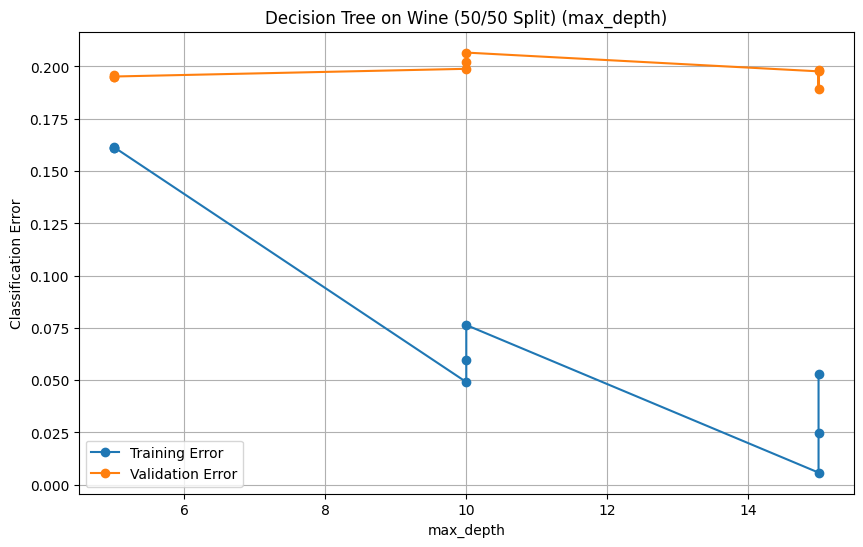

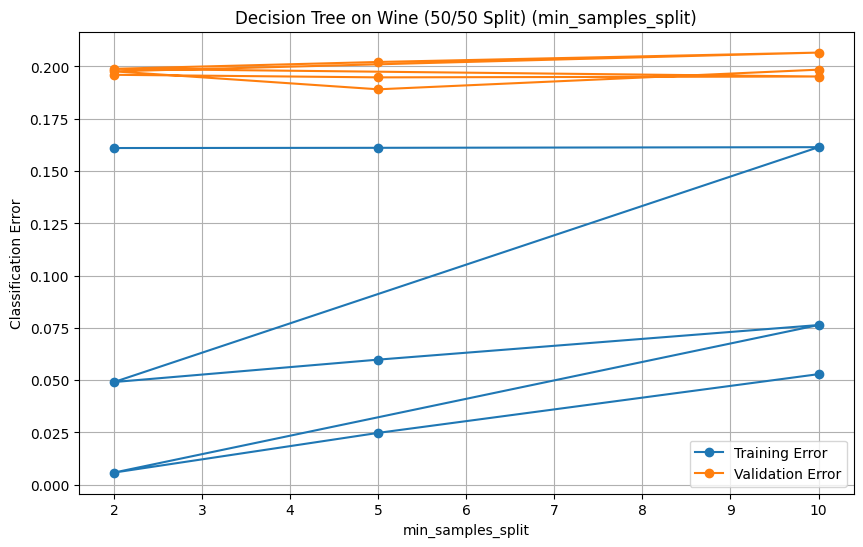

  Aggregated Confusion Matrix:
[[5144  599]
 [ 866  738]]



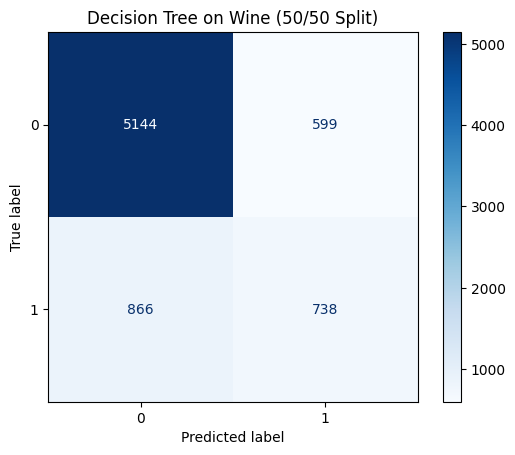

Results for Decision Tree on Wine (20/80 Split):
  Average Train Accuracy: 0.8965
  Average Train Error: 0.1035
  Average Validation Accuracy: 0.7988
  Average Validation Error: 0.2012
  Average Test Accuracy: 0.7923
  Average Test Error: 0.2077
  Test Precision: 0.5401
  Test Recall: 0.4287
  Test Precision: 0.6590
  Test Recall: 0.2026
  Test Precision: 0.4994
  Test Recall: 0.4798
  Average Test Precision: 0.5662
  Average Test Recall: 0.3704


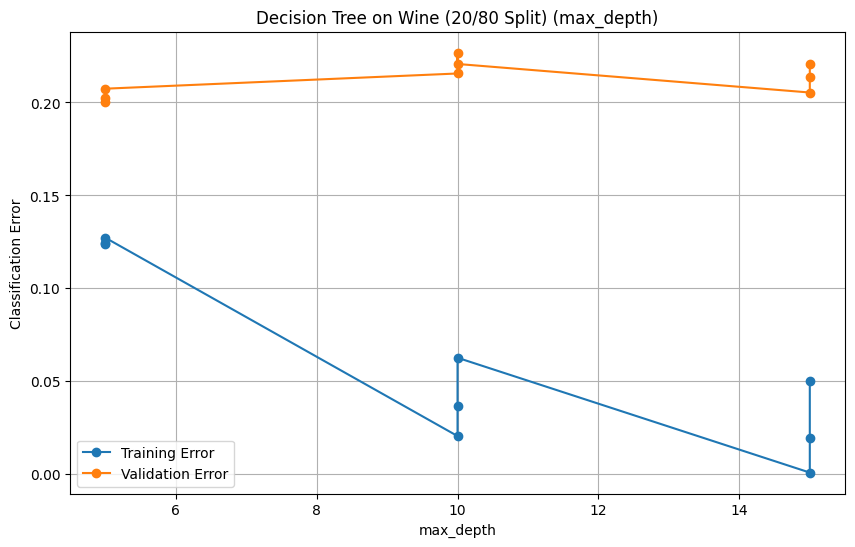

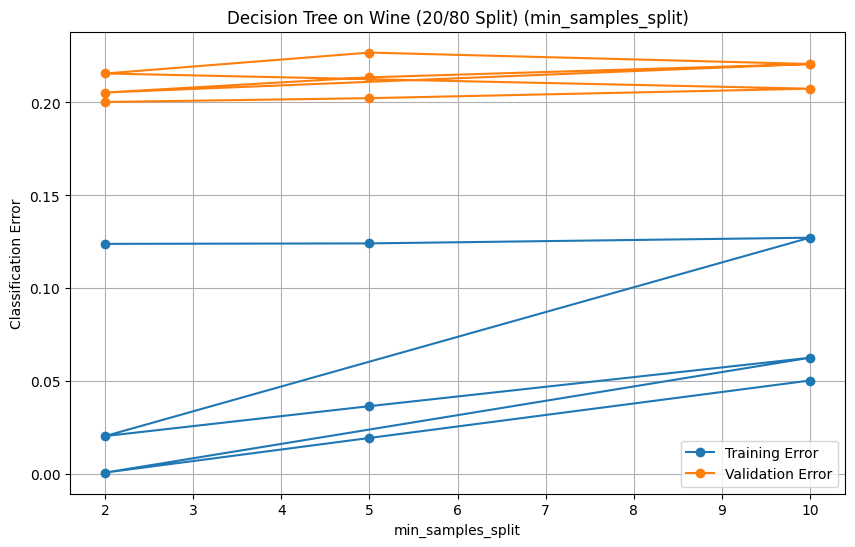

  Aggregated Confusion Matrix:
[[8357  821]
 [1621  958]]



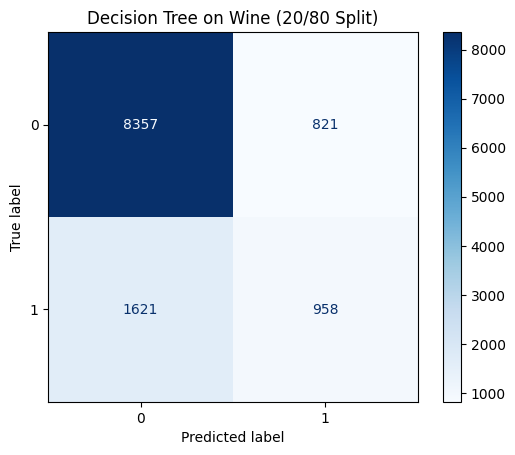

Best Validation Accuracy for Decision Tree on Wine dataset: 0.8127 (Partition: 80/19)

Best Test Accuracy for Decision Tree on Wine dataset: 0.8248

Best Train Accuracy for Decision Tree on Wine dataset: 0.9748



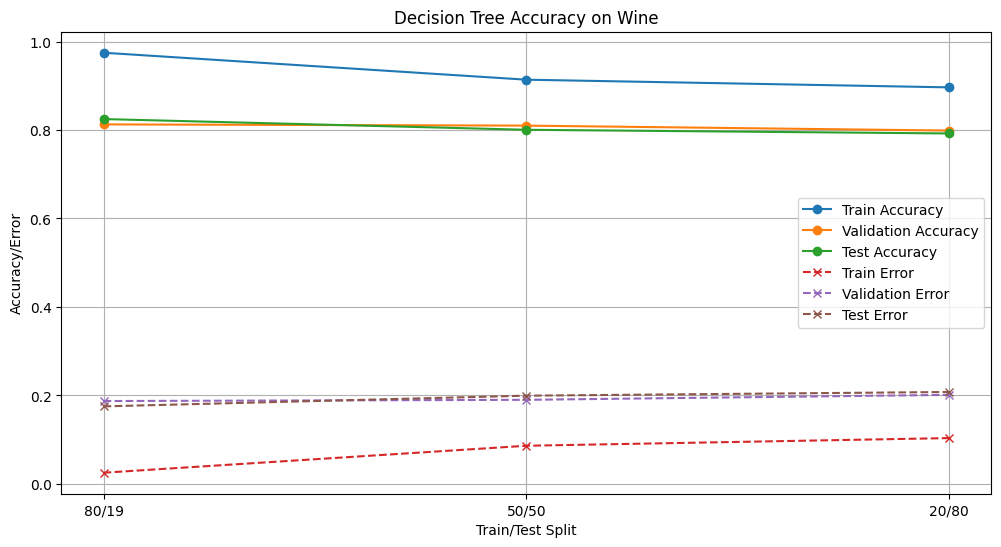


Running KNN on Wine dataset...



/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Results for KNN on Wine (80/19 Split):
  Average Train Accuracy: 1.0000
  Average Train Error: 0.0000
  Average Validation Accuracy: 0.8636
  Average Validation Error: 0.1364
  Average Test Accuracy: 0.8728
  Average Test Error: 0.1272
  Test Precision: 0.6898
  Test Recall: 0.6355
  Test Precision: 0.7473
  Test Recall: 0.6355
  Test Precision: 0.7246
  Test Recall: 0.6269
  Average Test Precision: 0.7205
  Average Test Recall: 0.6326


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


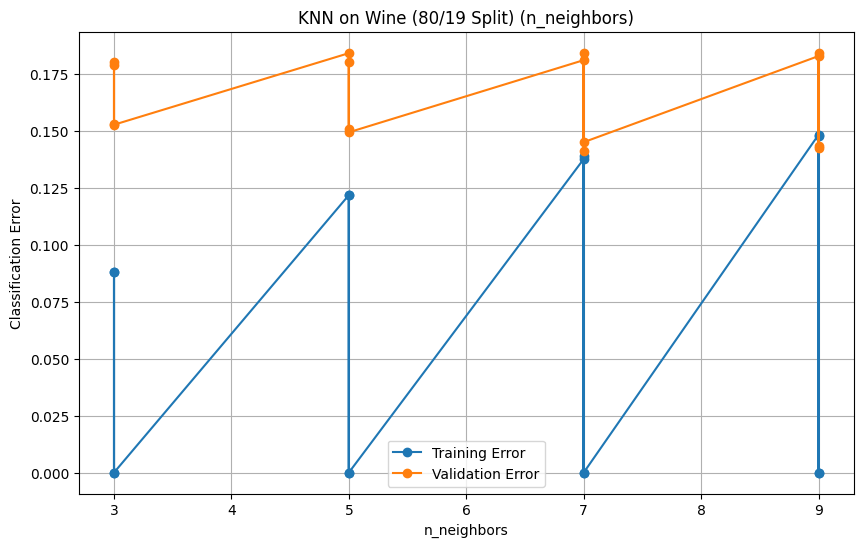

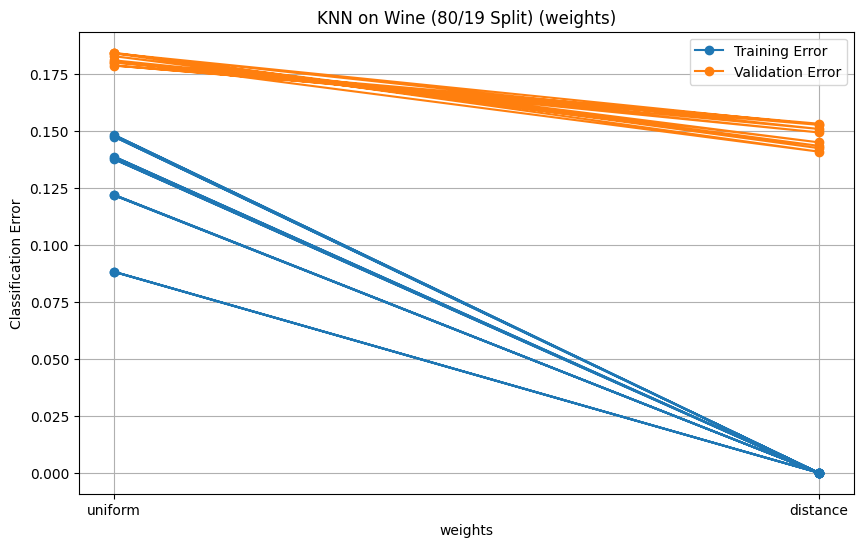

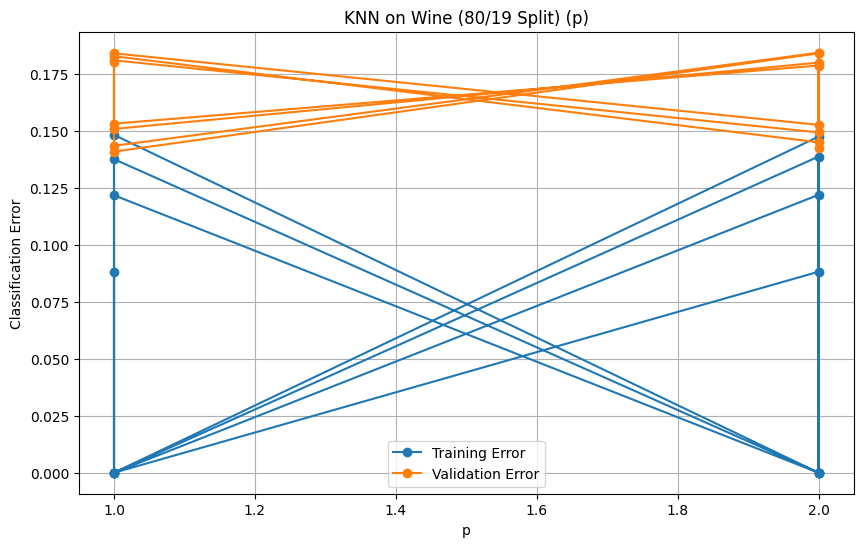

  Aggregated Confusion Matrix:
[[2180  150]
 [ 224  386]]



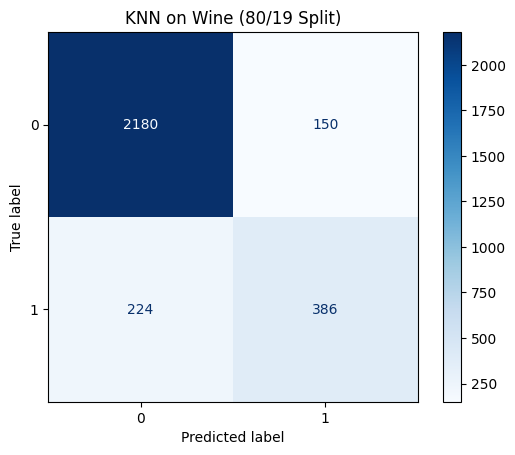

Results for KNN on Wine (50/50 Split):
  Average Train Accuracy: 1.0000
  Average Train Error: 0.0000
  Average Validation Accuracy: 0.8474
  Average Validation Error: 0.1526
  Average Test Accuracy: 0.8516
  Average Test Error: 0.1484
  Test Precision: 0.6426
  Test Recall: 0.5969
  Test Precision: 0.7010
  Test Recall: 0.5689
  Test Precision: 0.6765
  Test Recall: 0.5795
  Average Test Precision: 0.6733
  Average Test Recall: 0.5818


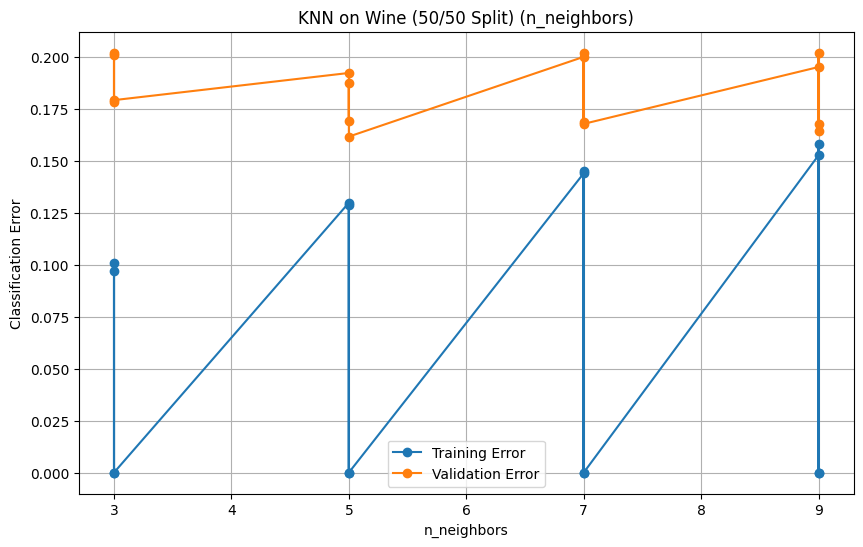

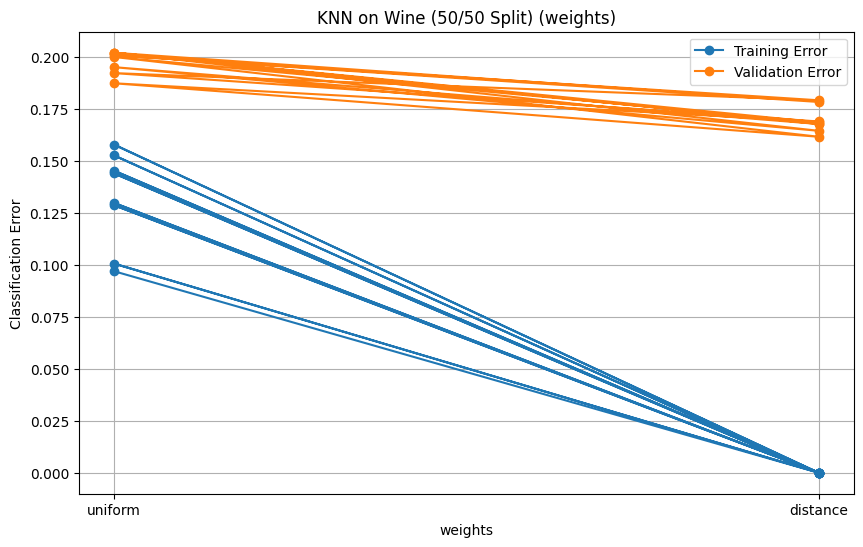

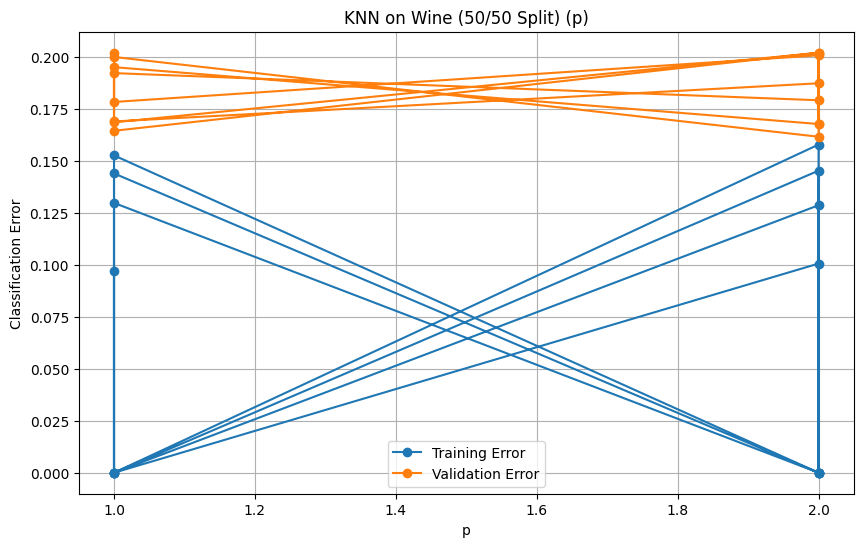

  Aggregated Confusion Matrix:
[[5354  441]
 [ 649  903]]



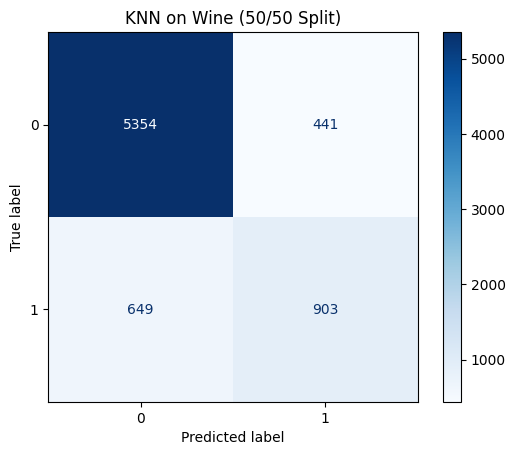

Results for KNN on Wine (20/80 Split):
  Average Train Accuracy: 1.0000
  Average Train Error: 0.0000
  Average Validation Accuracy: 0.8202
  Average Validation Error: 0.1798
  Average Test Accuracy: 0.8126
  Average Test Error: 0.1874
  Test Precision: 0.6173
  Test Recall: 0.4241
  Test Precision: 0.5424
  Test Recall: 0.4835
  Test Precision: 0.6213
  Test Recall: 0.4454
  Average Test Precision: 0.5937
  Average Test Recall: 0.4510


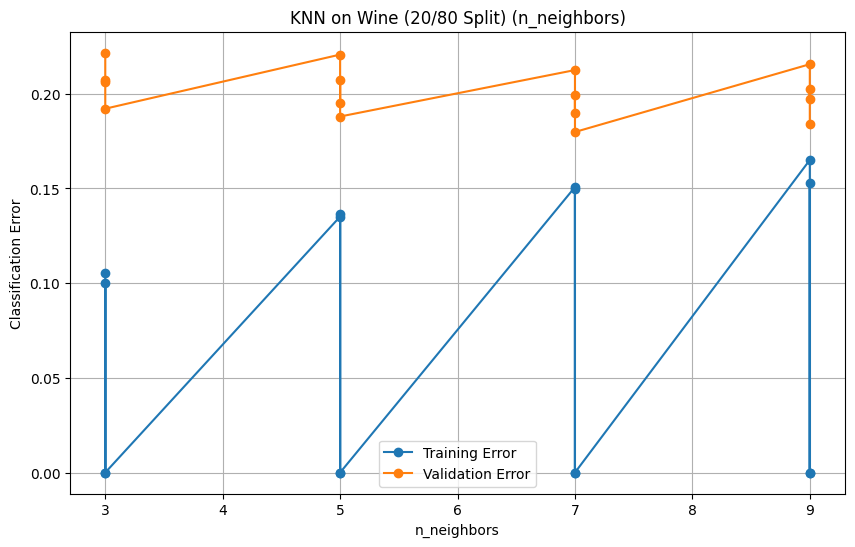

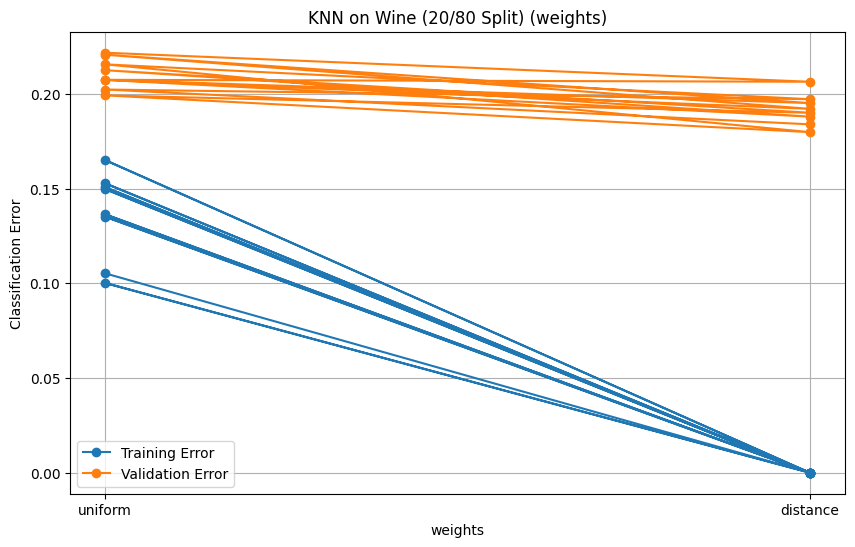

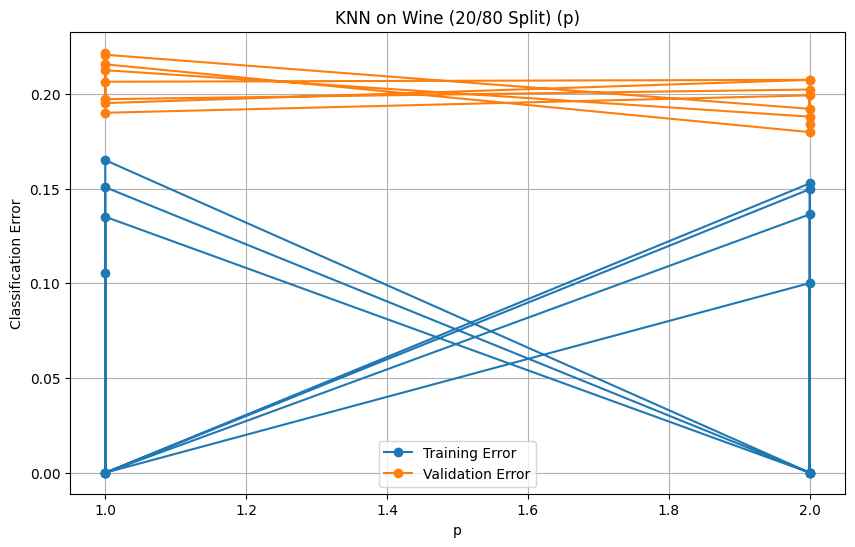

  Aggregated Confusion Matrix:
[[8403  801]
 [1402 1151]]



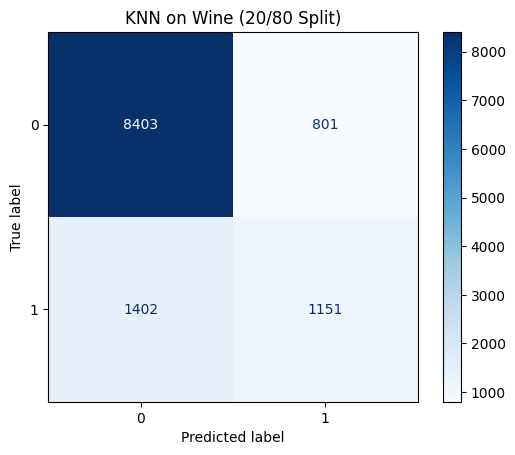

Best Validation Accuracy for KNN on Wine dataset: 0.8636 (Partition: 80/19)

Best Test Accuracy for KNN on Wine dataset: 0.8728

Best Train Accuracy for KNN on Wine dataset: 1.0000



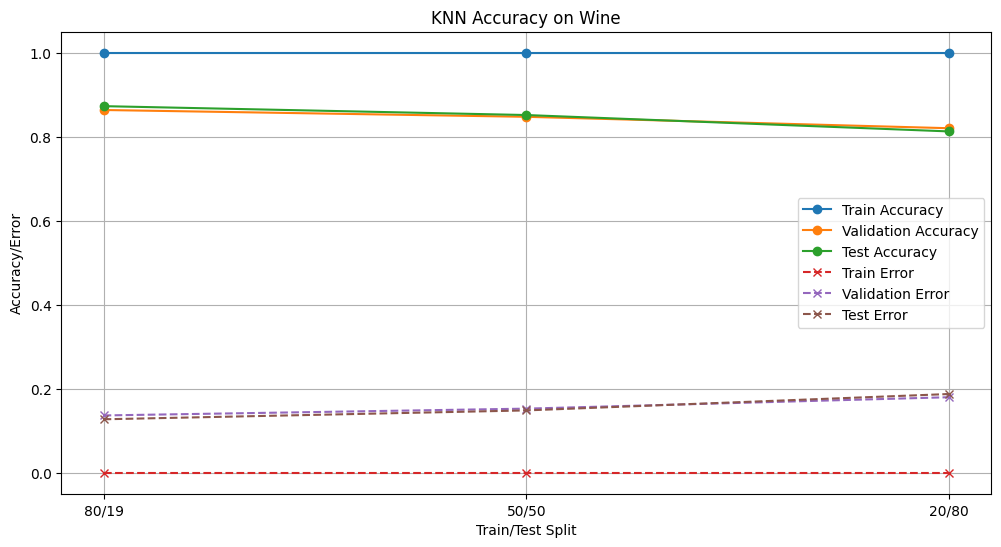


Running Random Forest on Wine dataset...



/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Results for Random Forest on Wine (80/19 Split):
  Average Train Accuracy: 0.9986
  Average Train Error: 0.0014
  Average Validation Accuracy: 0.8732
  Average Validation Error: 0.1268
  Average Test Accuracy: 0.8718
  Average Test Error: 0.1282
  Test Precision: 0.7947
  Test Recall: 0.5634
  Test Precision: 0.8485
  Test Recall: 0.6167
  Test Precision: 0.7730
  Test Recall: 0.5478
  Average Test Precision: 0.8054
  Average Test Recall: 0.5760


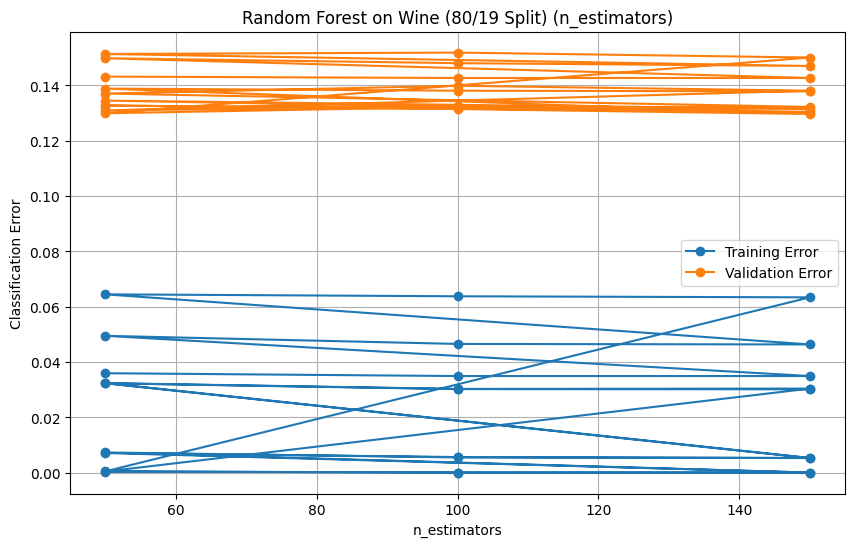

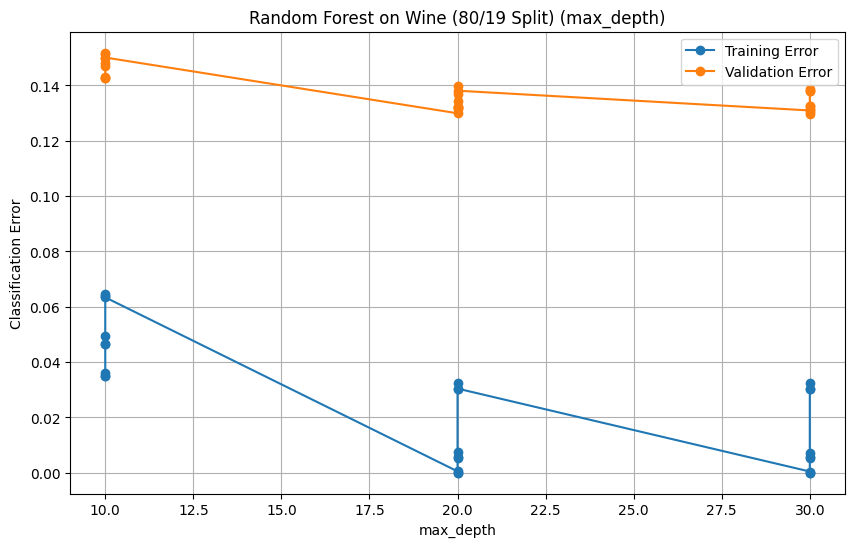

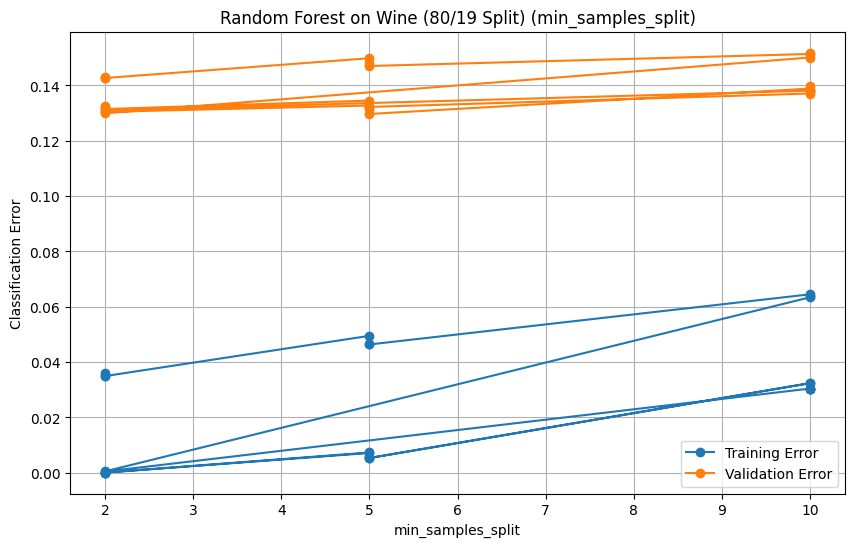

  Aggregated Confusion Matrix:
[[2177   93]
 [ 284  386]]



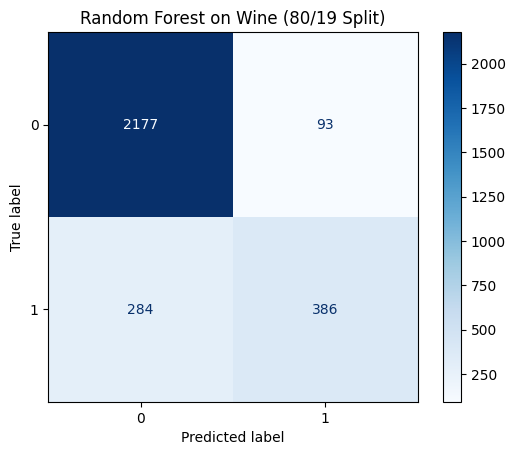

Results for Random Forest on Wine (50/50 Split):
  Average Train Accuracy: 0.9977
  Average Train Error: 0.0023
  Average Validation Accuracy: 0.8511
  Average Validation Error: 0.1489
  Average Test Accuracy: 0.8632
  Average Test Error: 0.1368
  Test Precision: 0.7486
  Test Recall: 0.5178
  Test Precision: 0.7675
  Test Recall: 0.5141
  Test Precision: 0.7932
  Test Recall: 0.5204
  Average Test Precision: 0.7698
  Average Test Recall: 0.5174


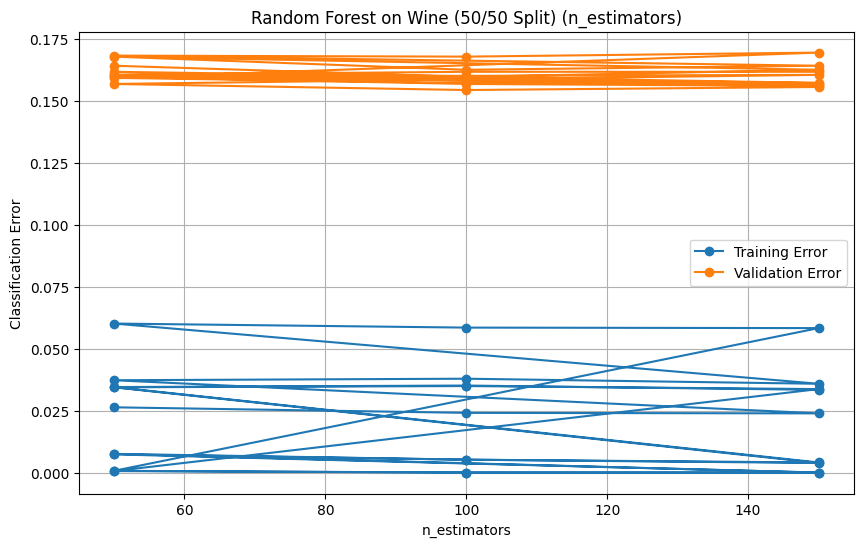

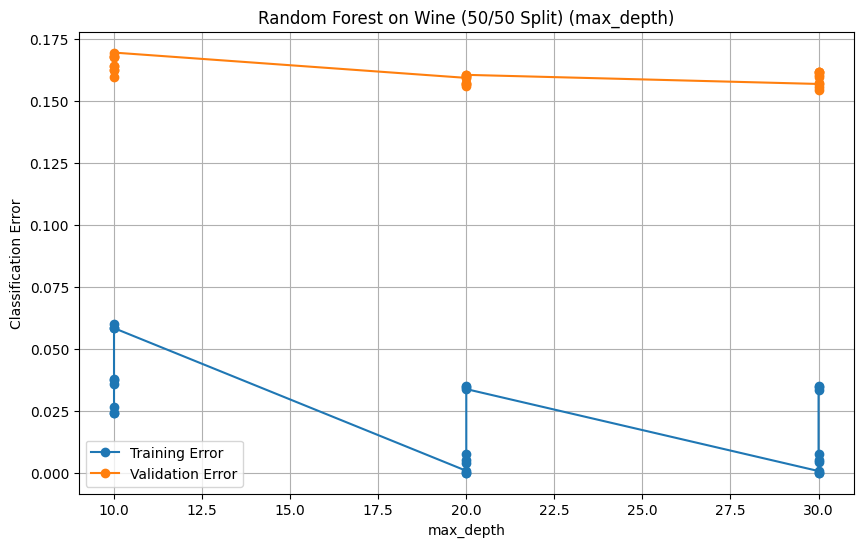

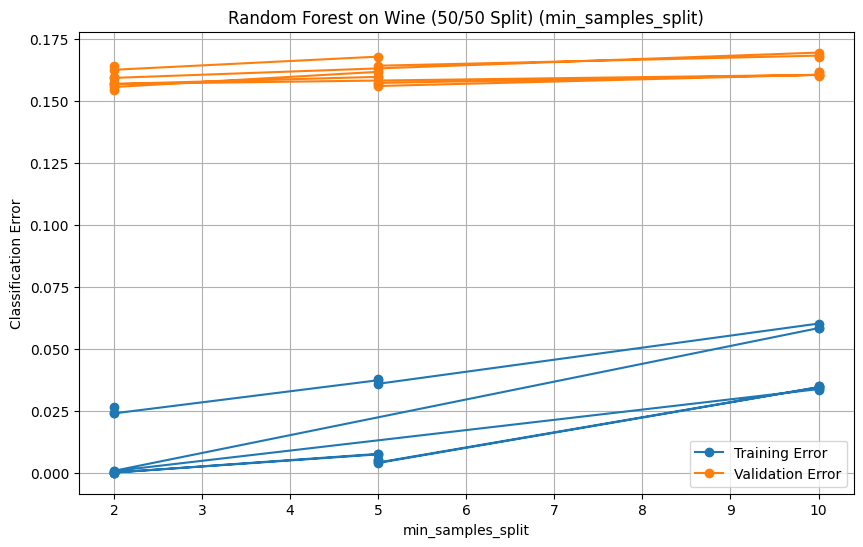

  Aggregated Confusion Matrix:
[[5526  244]
 [ 761  816]]



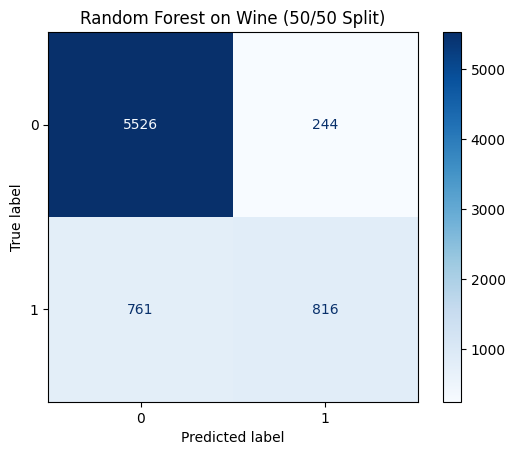

Results for Random Forest on Wine (20/80 Split):
  Average Train Accuracy: 0.9942
  Average Train Error: 0.0058
  Average Validation Accuracy: 0.8318
  Average Validation Error: 0.1682
  Average Test Accuracy: 0.8290
  Average Test Error: 0.1710
  Test Precision: 0.6477
  Test Recall: 0.4470
  Test Precision: 0.6560
  Test Recall: 0.4107
  Test Precision: 0.7089
  Test Recall: 0.3902
  Average Test Precision: 0.6708
  Average Test Recall: 0.4160


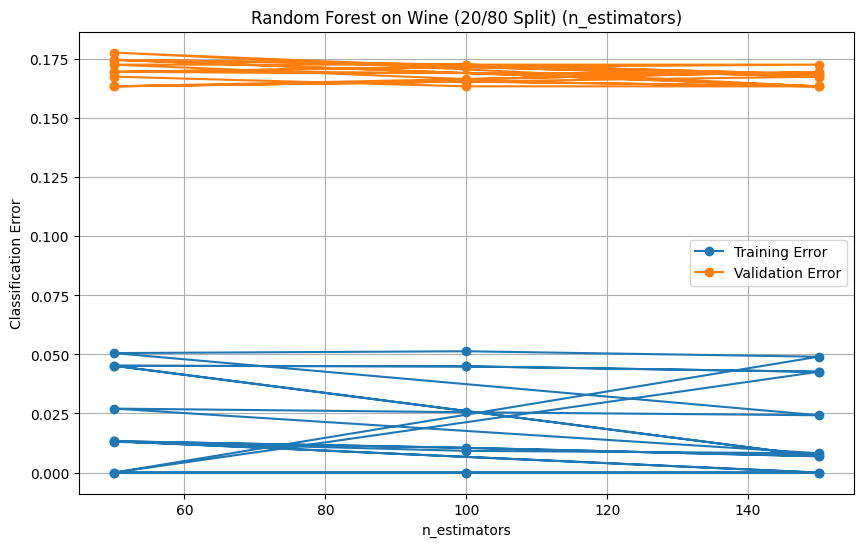

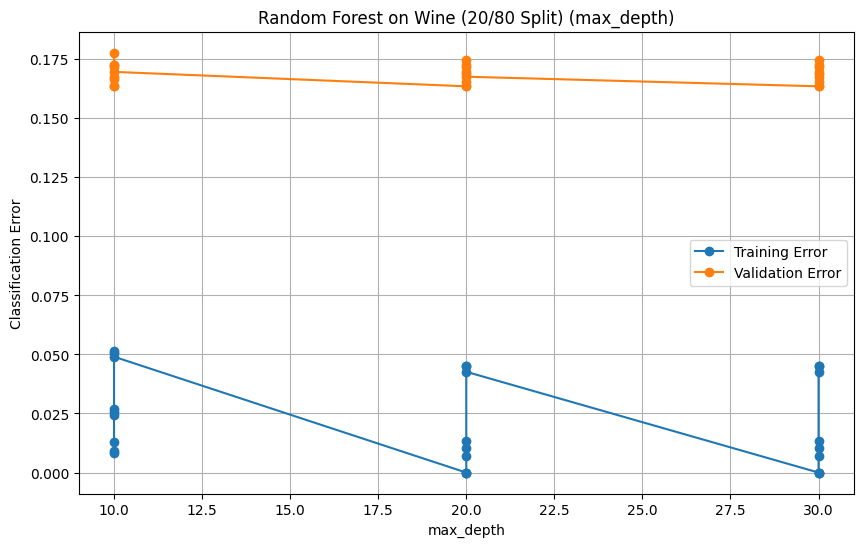

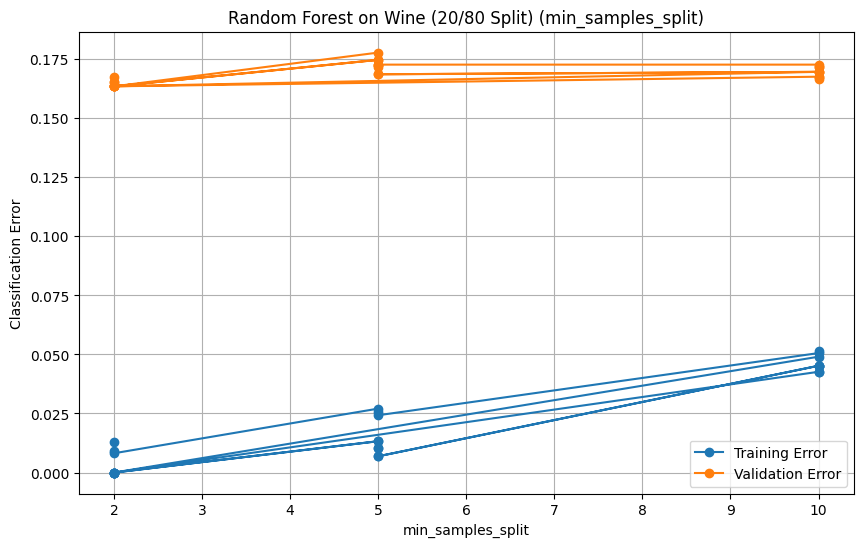

  Aggregated Confusion Matrix:
[[8688  524]
 [1487 1058]]



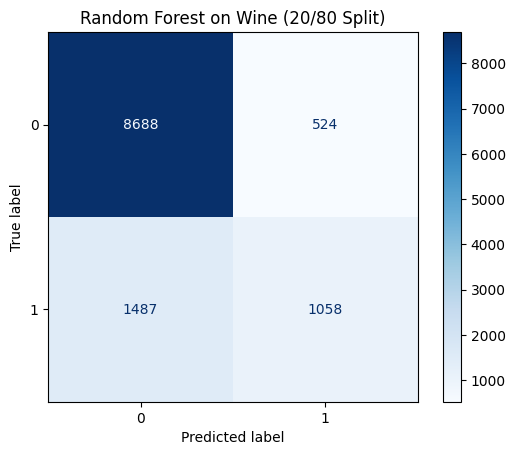

Best Validation Accuracy for Random Forest on Wine dataset: 0.8732 (Partition: 80/19)

Best Test Accuracy for Random Forest on Wine dataset: 0.8718

Best Train Accuracy for Random Forest on Wine dataset: 0.9986



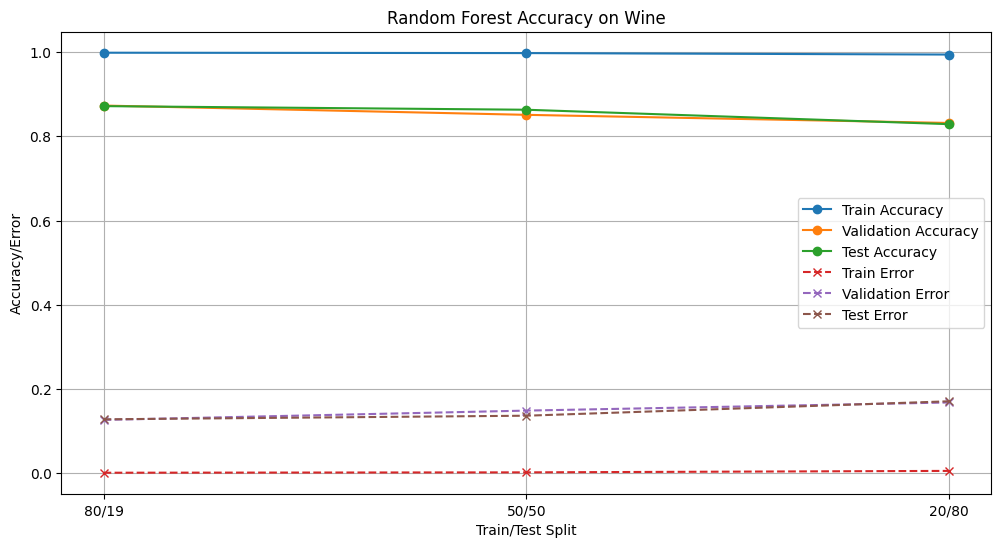

In [7]:
print("\n========== Running Models on Wine Dataset ==========")
X_wine, y_wine = preprocess_wine(wine_file)
X_wine = scale_data(X_wine)
wine_results = []  
for clf_name, (clf, param_grid) in classifiers.items():
    print(f"\nRunning {clf_name} on Wine dataset...\n")
    results = train_and_evaluate_with_confusion(clf, param_grid, X_wine, y_wine, partitions=partitions)

    best_score = 0  
    best_partition = None  
    best_test_score = 0  
    best_train_score = 0  

    for partition, result in results.items():
        print(f"Results for {clf_name} on Wine ({partition} Split):")
        print(f"  Average Train Accuracy: {result['average_train_accuracy']:.4f}")
        print(f"  Average Train Error: {1 - result['average_train_accuracy']:.4f}")
        print(f"  Average Validation Accuracy: {result['average_validation_accuracy']:.4f}")
        print(f"  Average Validation Error: {1 - result['average_validation_accuracy']:.4f}")
        print(f"  Average Test Accuracy: {result['average_test_accuracy']:.4f}")
        print(f"  Average Test Error: {1 - result['average_test_accuracy']:.4f}")

        for trial in result['all_trials']:
            print(f"  Test Precision: {trial['test_precision']:.4f}")
            print(f"  Test Recall: {trial['test_recall']:.4f}")

        avg_precision = np.mean([trial['test_precision'] for trial in result['all_trials']])
        avg_recall = np.mean([trial['test_recall'] for trial in result['all_trials']])
        print(f"  Average Test Precision: {avg_precision:.4f}")
        print(f"  Average Test Recall: {avg_recall:.4f}")


        if result['average_validation_accuracy'] > best_score:
            best_score = result['average_validation_accuracy']
            best_partition = partition

        if result['average_test_accuracy'] > best_test_score:
            best_test_score = result['average_test_accuracy']

        if result['average_train_accuracy'] > best_train_score:
            best_train_score = result['average_train_accuracy']

        trial = result['all_trials'][0]
        for hyperparam in param_grid.keys():
            plot_error_curves(trial['cv_results'], hyperparam, f"{clf_name} on Wine ({partition} Split)")

        aggregated_confusion = sum(np.array(t['confusion_matrix']) for t in result['all_trials'])
        print(f"  Aggregated Confusion Matrix:\n{aggregated_confusion}\n")
        plot_confusion_matrix(aggregated_confusion, f"{clf_name} on Wine ({partition} Split)")

    print(f"Best Validation Accuracy for {clf_name} on Wine dataset: {best_score:.4f} (Partition: {best_partition})\n")
    print(f"Best Test Accuracy for {clf_name} on Wine dataset: {best_test_score:.4f}\n")
    print(f"Best Train Accuracy for {clf_name} on Wine dataset: {best_train_score:.4f}\n")
    plot_results(results, f"{clf_name} Accuracy on Wine")

    wine_results.append((clf_name, best_partition, best_score, best_test_score, best_train_score))



========== Running Models on Abalone Dataset ==========

Running Decision Tree on Abalone dataset...

Results for Decision Tree on Abalone (80/19 Split):
  Average Train Accuracy: 0.8075
  Average Train Error: 0.1925
  Average Validation Accuracy: 0.7815
  Average Validation Error: 0.2185
  Average Test Accuracy: 0.7675
  Average Test Error: 0.2325
  Test Precision: 0.7383
  Test Recall: 0.7990
  Test Precision: 0.7332
  Test Recall: 0.8103
  Test Precision: 0.7568
  Test Recall: 0.7606
  Average Test Precision: 0.7428
  Average Test Recall: 0.7900


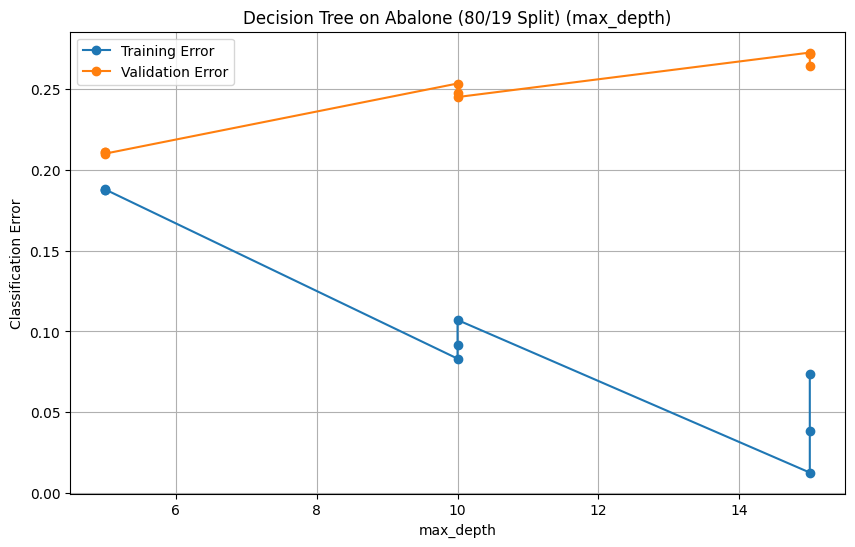

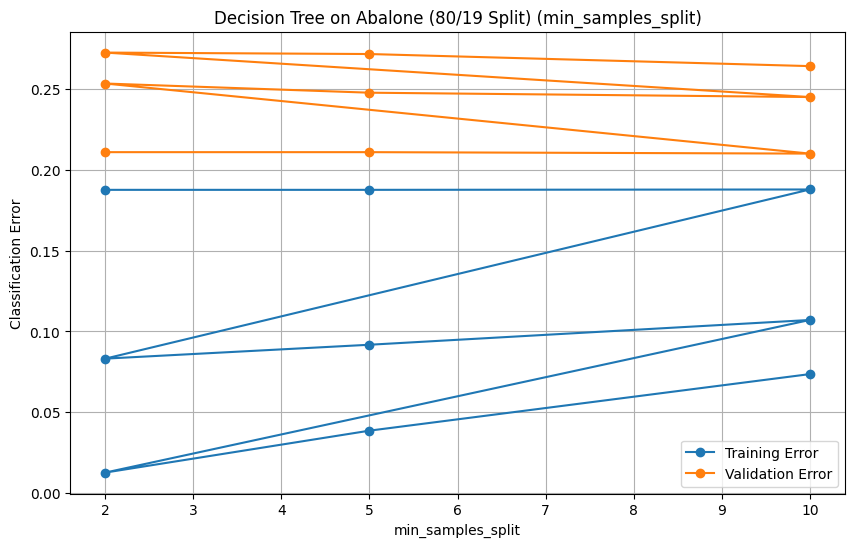

  Aggregated Confusion Matrix:
[[974 330]
 [253 951]]



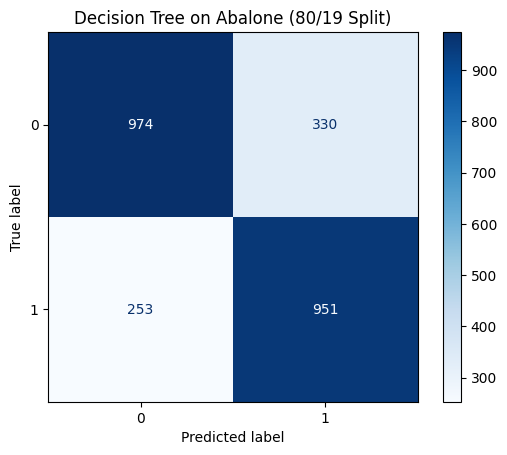

Results for Decision Tree on Abalone (50/50 Split):
  Average Train Accuracy: 0.8078
  Average Train Error: 0.1922
  Average Validation Accuracy: 0.7696
  Average Validation Error: 0.2304
  Average Test Accuracy: 0.7626
  Average Test Error: 0.2374
  Test Precision: 0.8139
  Test Recall: 0.6843
  Test Precision: 0.7516
  Test Recall: 0.7885
  Test Precision: 0.7540
  Test Recall: 0.7715
  Average Test Precision: 0.7732
  Average Test Recall: 0.7481


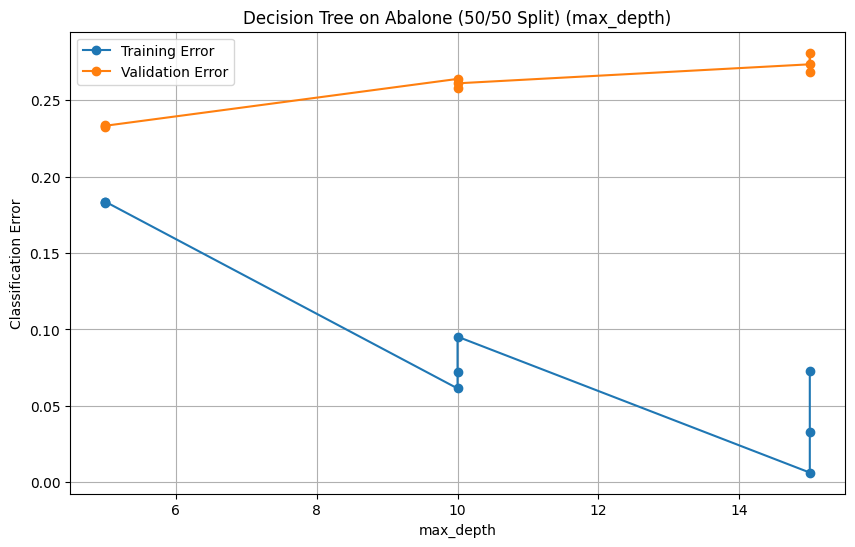

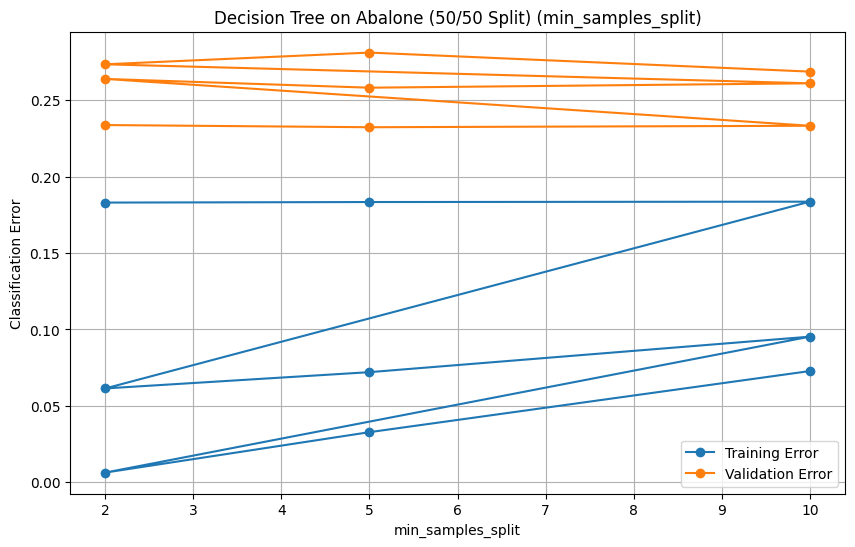

  Aggregated Confusion Matrix:
[[2436  697]
 [ 791 2343]]



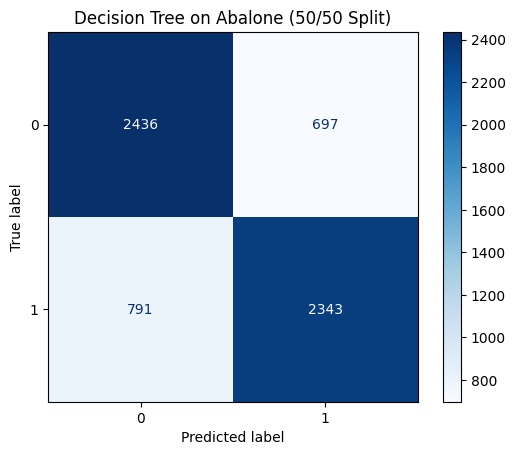

Results for Decision Tree on Abalone (20/80 Split):
  Average Train Accuracy: 0.8647
  Average Train Error: 0.1353
  Average Validation Accuracy: 0.7481
  Average Validation Error: 0.2519
  Average Test Accuracy: 0.7474
  Average Test Error: 0.2526
  Test Precision: 0.7293
  Test Recall: 0.7066
  Test Precision: 0.7857
  Test Recall: 0.7251
  Test Precision: 0.7906
  Test Recall: 0.7065
  Average Test Precision: 0.7685
  Average Test Recall: 0.7127


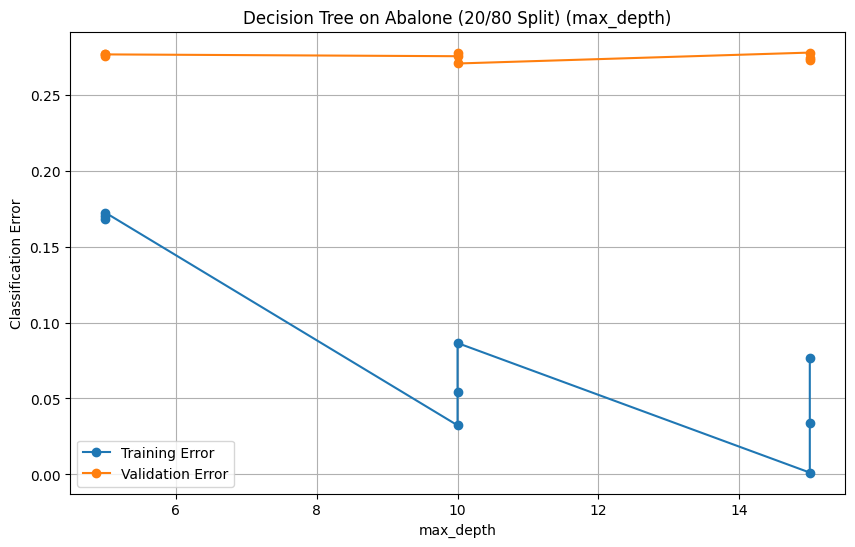

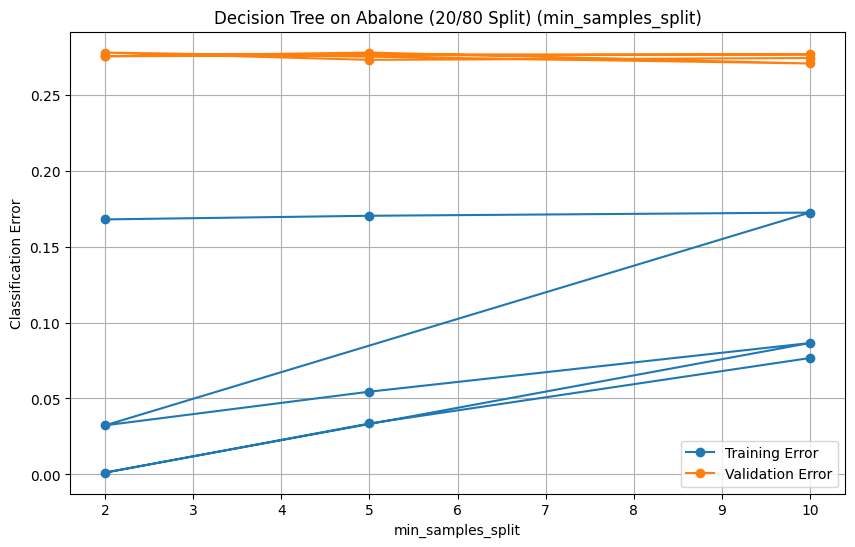

  Aggregated Confusion Matrix:
[[3903 1086]
 [1447 3590]]



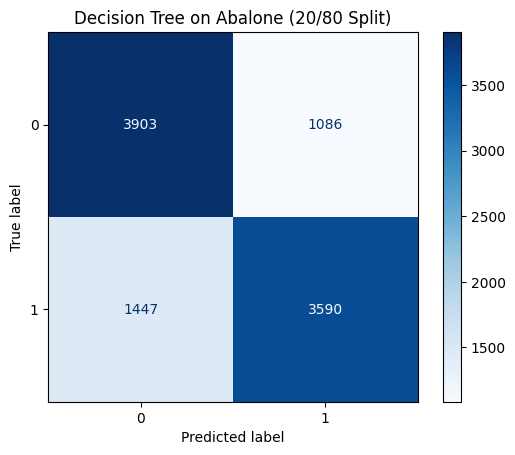

Best Validation Accuracy for Decision Tree on Abalone dataset: 0.7815 (Partition: 80/19)

Best Test Accuracy for Decision Tree on Abalone dataset: 0.7675

Best Train Accuracy for Decision Tree on Abalone dataset: 0.8647



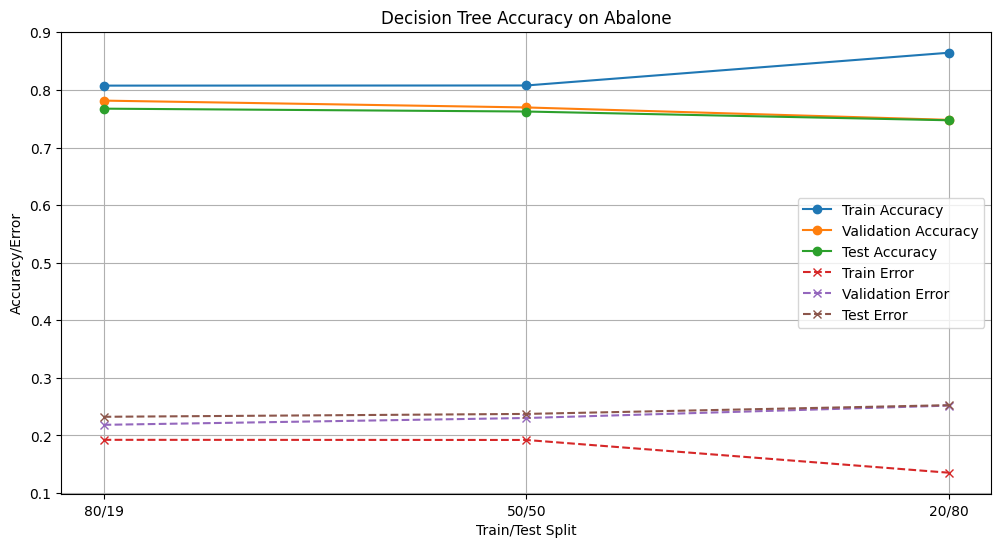


Running KNN on Abalone dataset...



/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Results for KNN on Abalone (80/19 Split):
  Average Train Accuracy: 0.9381
  Average Train Error: 0.0619
  Average Validation Accuracy: 0.7763
  Average Validation Error: 0.2237
  Average Test Accuracy: 0.7899
  Average Test Error: 0.2101
  Test Precision: 0.7873
  Test Recall: 0.8329
  Test Precision: 0.7671
  Test Recall: 0.8049
  Test Precision: 0.7832
  Test Recall: 0.7943
  Average Test Precision: 0.7792
  Average Test Recall: 0.8107


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


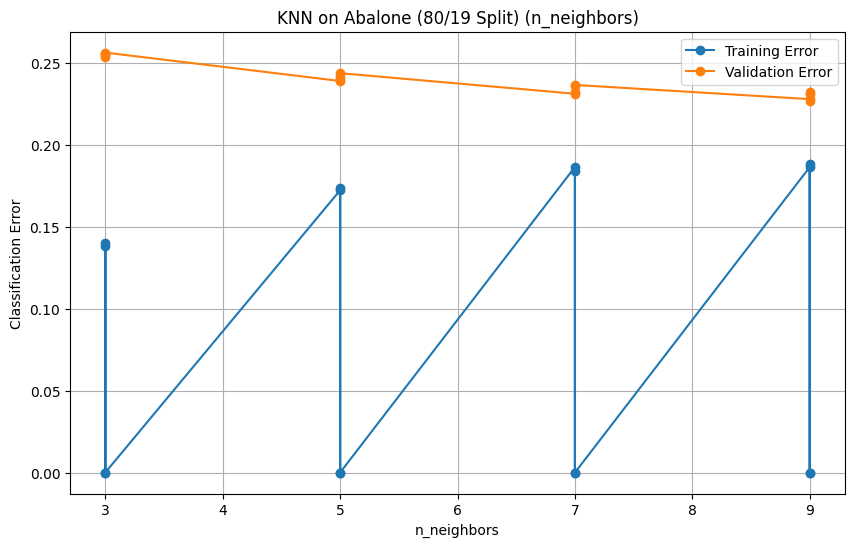

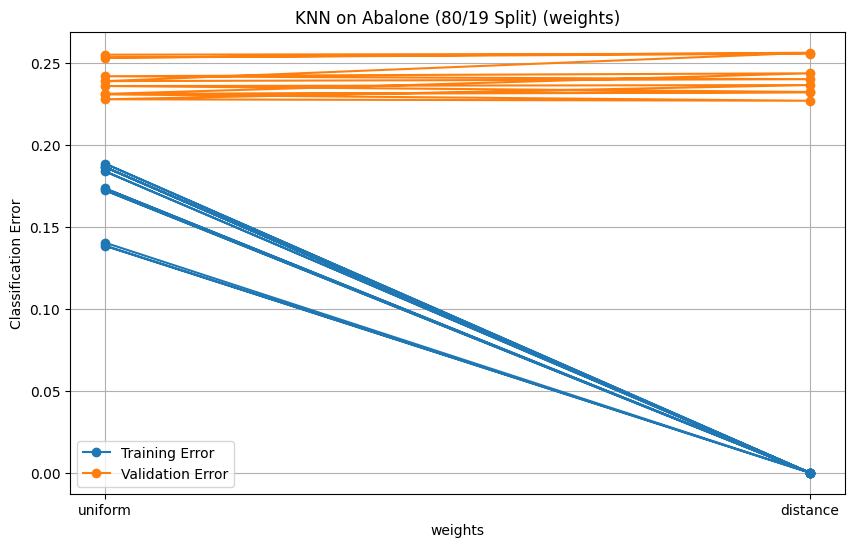

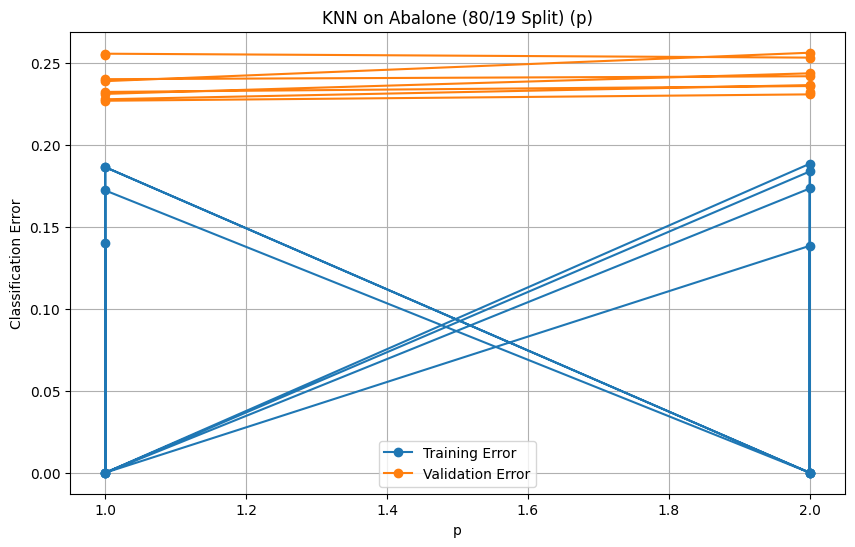

  Aggregated Confusion Matrix:
[[ 960  289]
 [ 238 1021]]



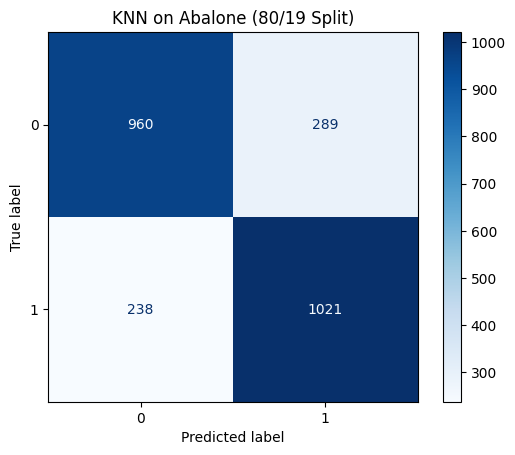

Results for KNN on Abalone (50/50 Split):
  Average Train Accuracy: 0.8883
  Average Train Error: 0.1117
  Average Validation Accuracy: 0.7786
  Average Validation Error: 0.2214
  Average Test Accuracy: 0.7699
  Average Test Error: 0.2301
  Test Precision: 0.7544
  Test Recall: 0.7850
  Test Precision: 0.7713
  Test Recall: 0.7802
  Test Precision: 0.7559
  Test Recall: 0.7948
  Average Test Precision: 0.7605
  Average Test Recall: 0.7867


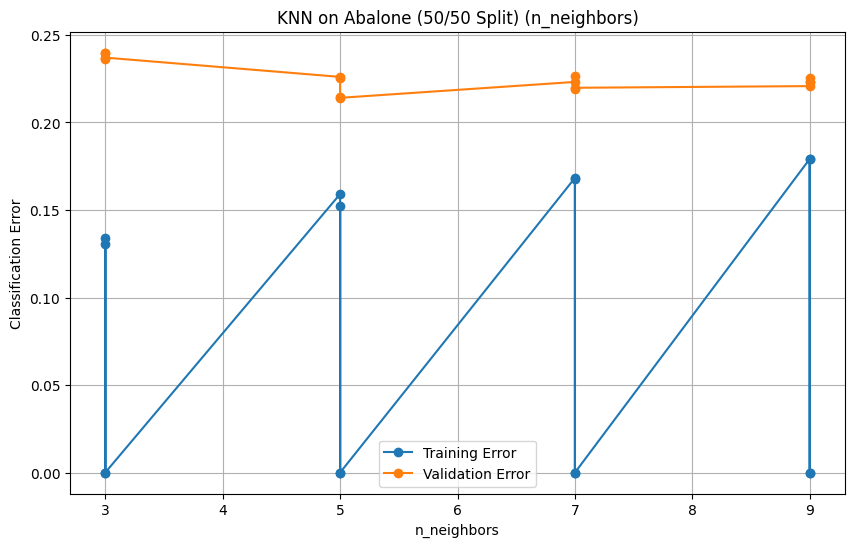

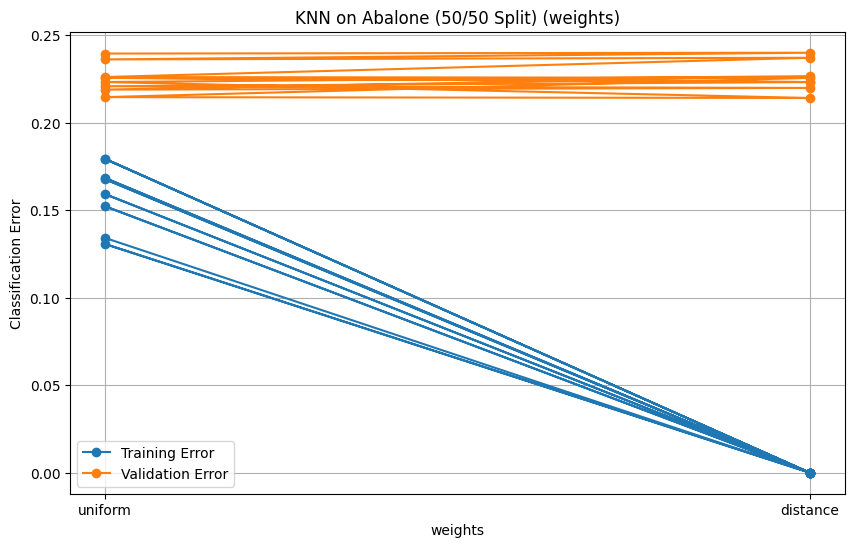

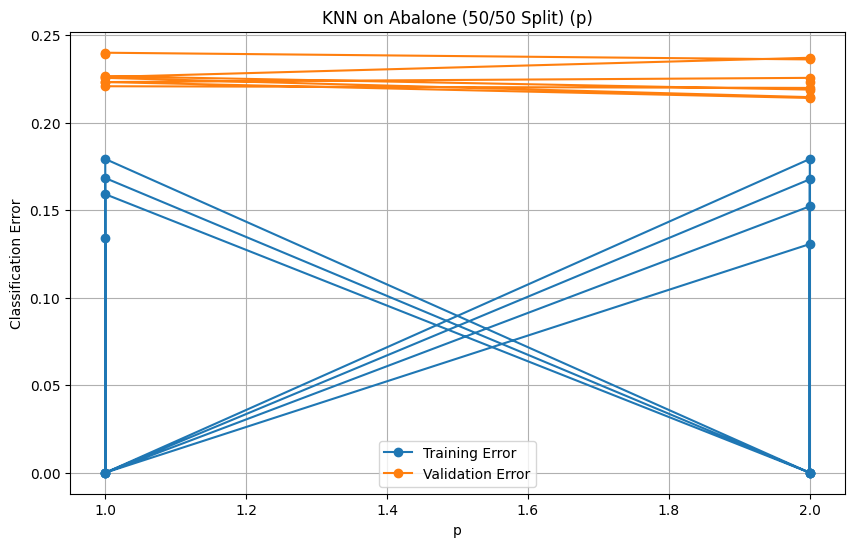

  Aggregated Confusion Matrix:
[[2365  775]
 [ 667 2460]]



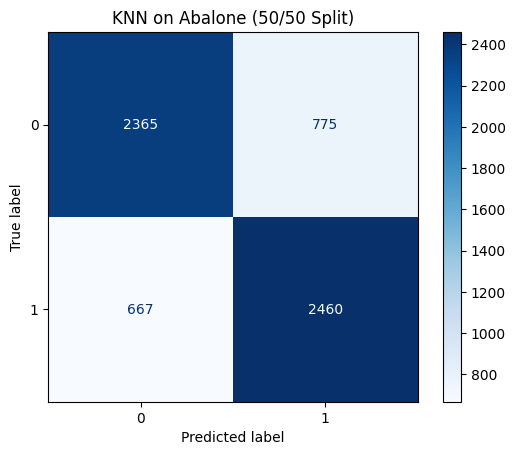

Results for KNN on Abalone (20/80 Split):
  Average Train Accuracy: 0.8958
  Average Train Error: 0.1042
  Average Validation Accuracy: 0.7912
  Average Validation Error: 0.2088
  Average Test Accuracy: 0.7685
  Average Test Error: 0.2315
  Test Precision: 0.7565
  Test Recall: 0.7911
  Test Precision: 0.7406
  Test Recall: 0.8183
  Test Precision: 0.7436
  Test Recall: 0.8115
  Average Test Precision: 0.7469
  Average Test Recall: 0.8070


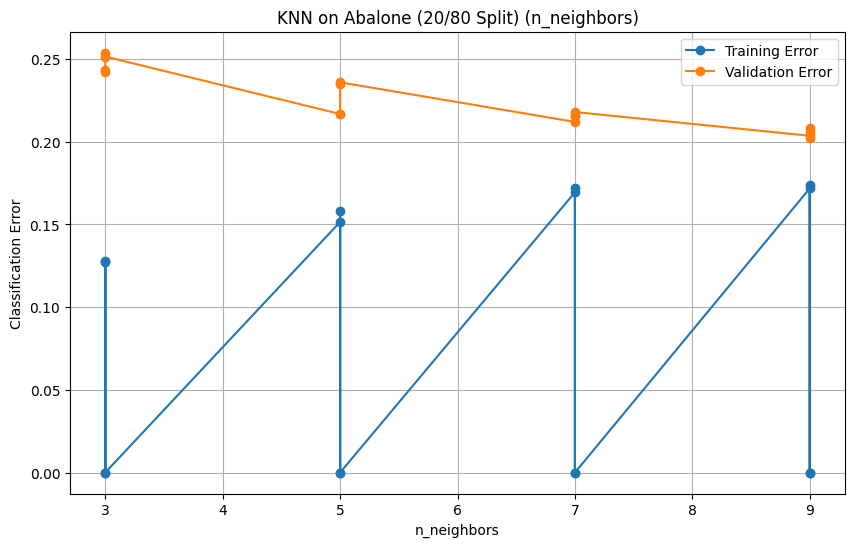

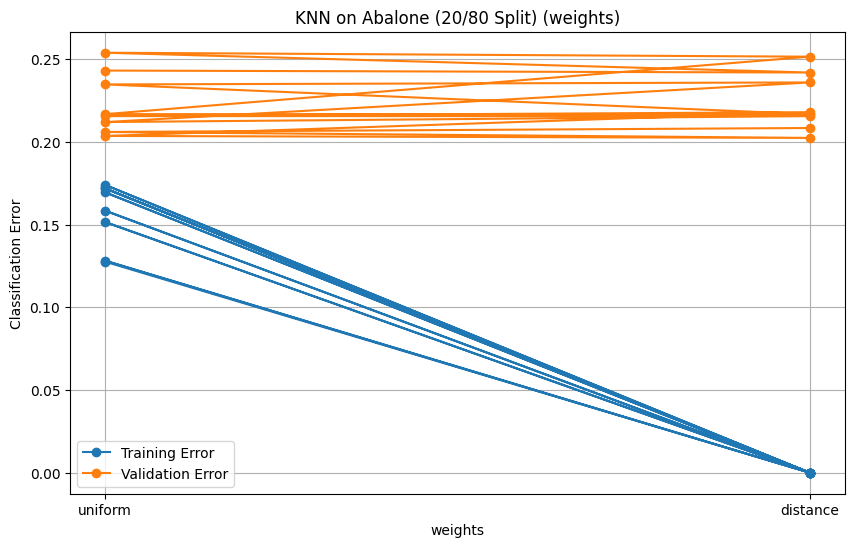

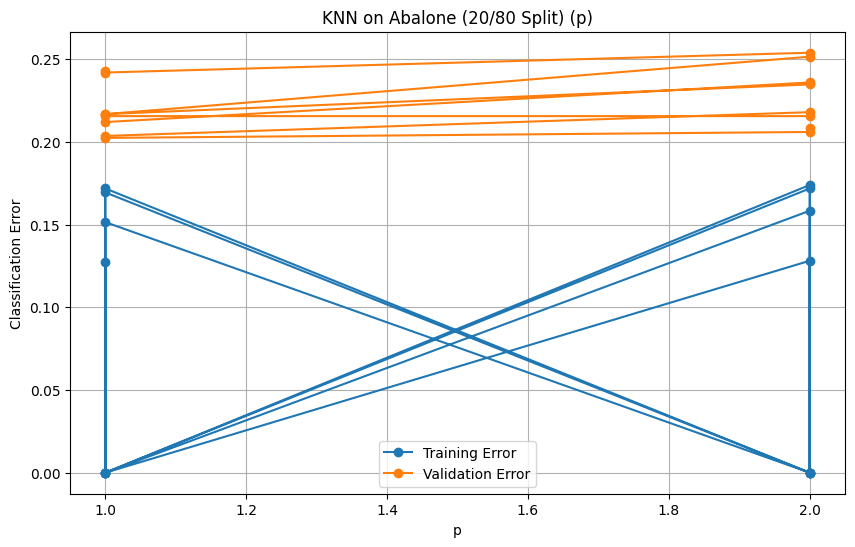

  Aggregated Confusion Matrix:
[[3692 1361]
 [ 960 4013]]



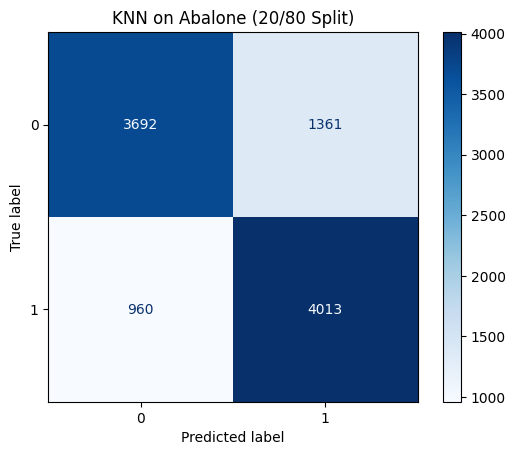

Best Validation Accuracy for KNN on Abalone dataset: 0.7912 (Partition: 20/80)

Best Test Accuracy for KNN on Abalone dataset: 0.7899

Best Train Accuracy for KNN on Abalone dataset: 0.9381



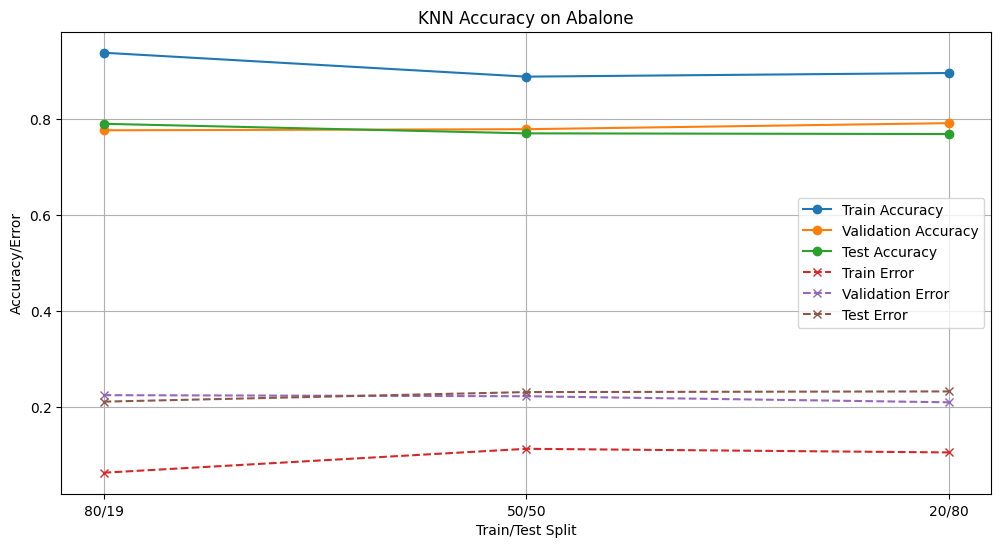


Running Random Forest on Abalone dataset...



/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Results for Random Forest on Abalone (80/19 Split):
  Average Train Accuracy: 0.9364
  Average Train Error: 0.0636
  Average Validation Accuracy: 0.7983
  Average Validation Error: 0.2017
  Average Test Accuracy: 0.8026
  Average Test Error: 0.1974
  Test Precision: 0.7973
  Test Recall: 0.8252
  Test Precision: 0.7743
  Test Recall: 0.8413
  Test Precision: 0.7970
  Test Recall: 0.8477
  Average Test Precision: 0.7895
  Average Test Recall: 0.8381


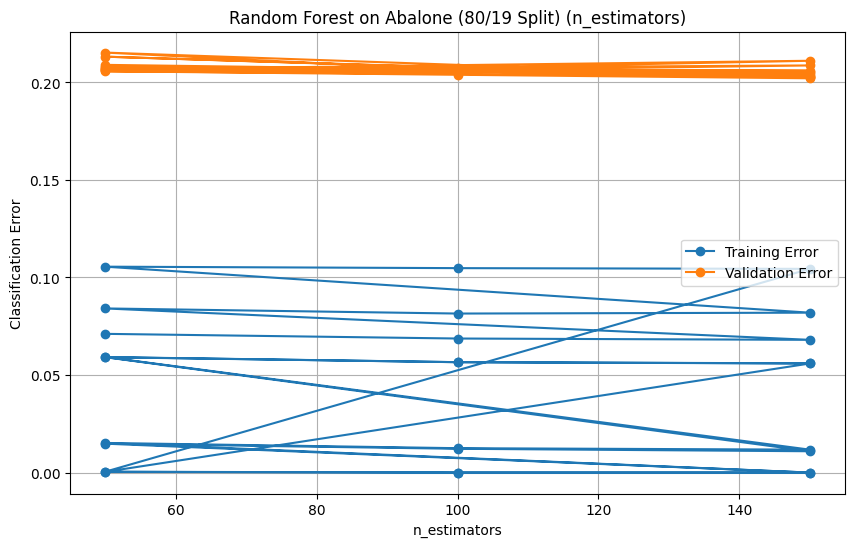

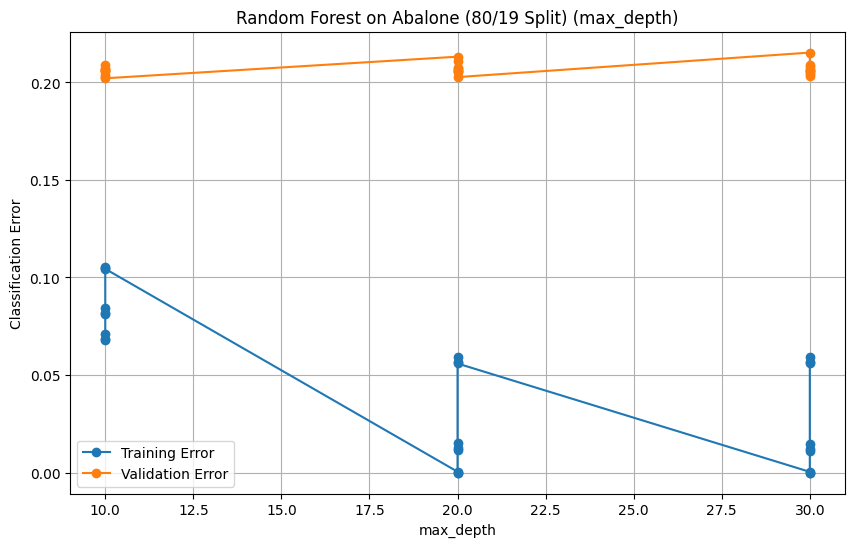

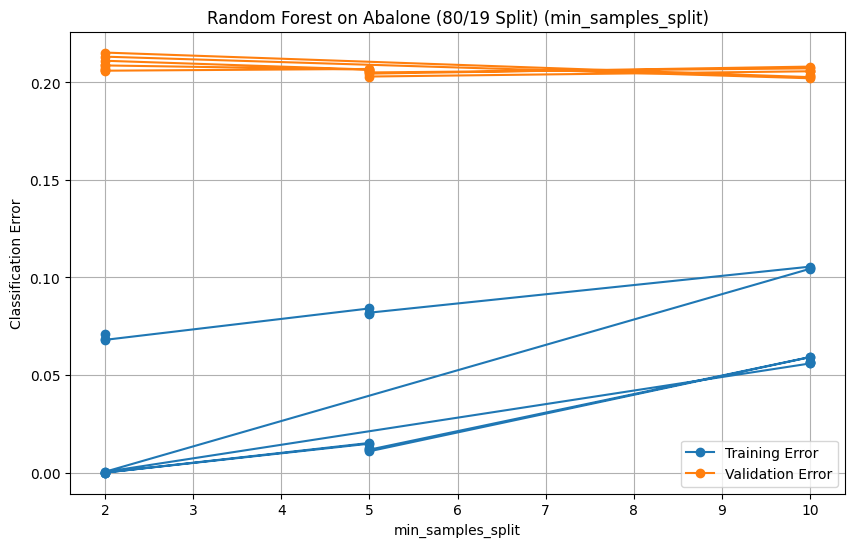

  Aggregated Confusion Matrix:
[[ 936  287]
 [ 208 1077]]



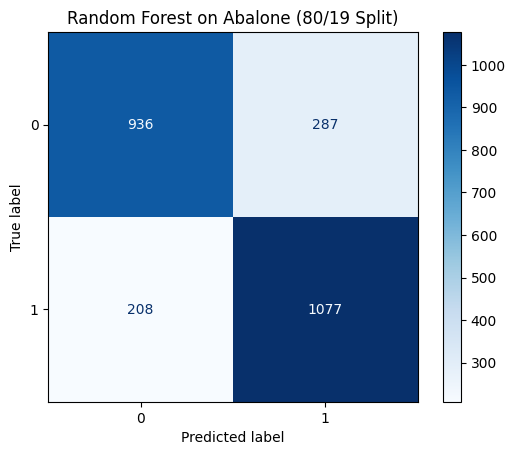

Results for Random Forest on Abalone (50/50 Split):
  Average Train Accuracy: 0.9393
  Average Train Error: 0.0607
  Average Validation Accuracy: 0.7971
  Average Validation Error: 0.2029
  Average Test Accuracy: 0.7937
  Average Test Error: 0.2063
  Test Precision: 0.7732
  Test Recall: 0.8081
  Test Precision: 0.7807
  Test Recall: 0.8179
  Test Precision: 0.7832
  Test Recall: 0.8329
  Average Test Precision: 0.7790
  Average Test Recall: 0.8196


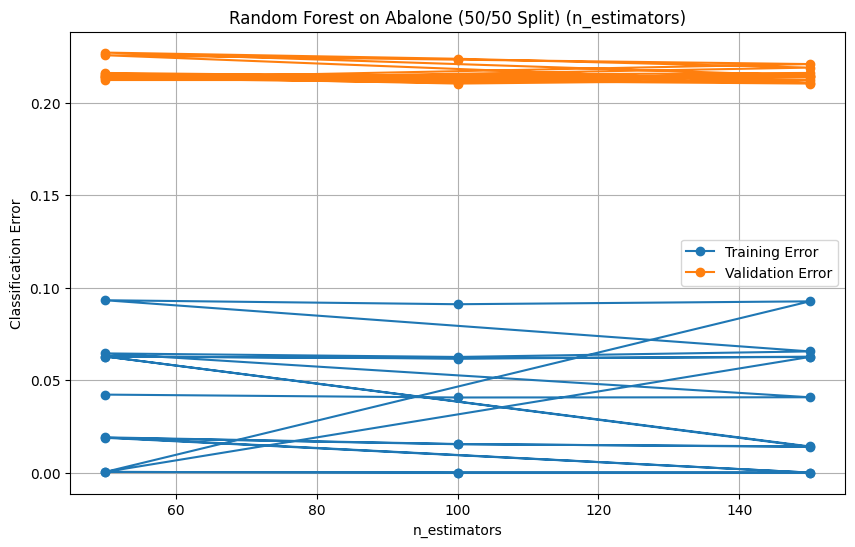

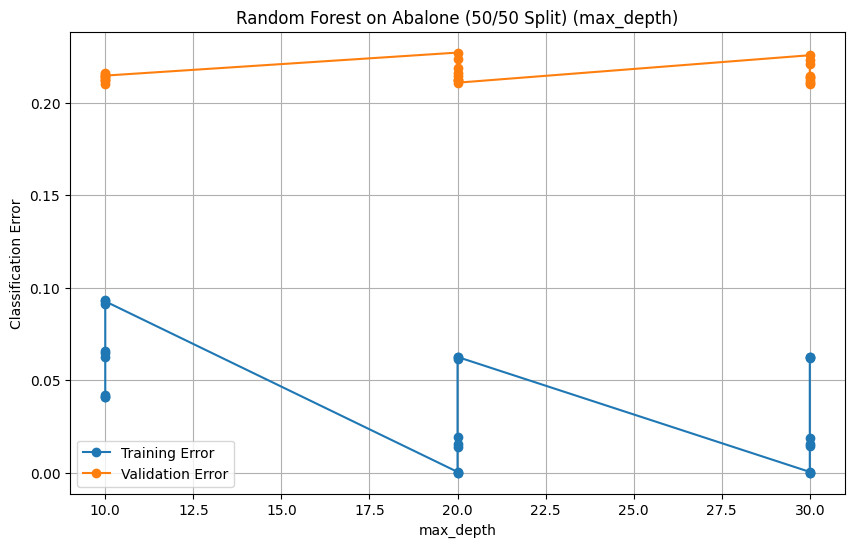

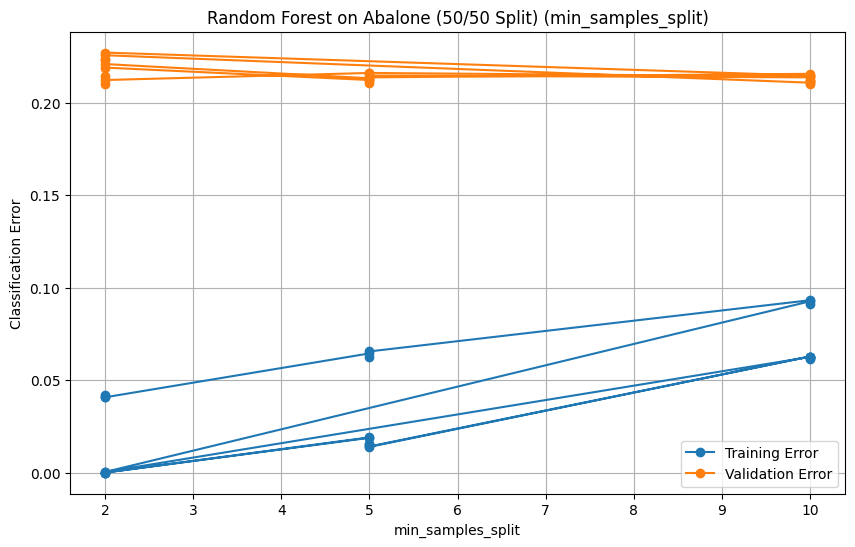

  Aggregated Confusion Matrix:
[[2407  728]
 [ 565 2567]]



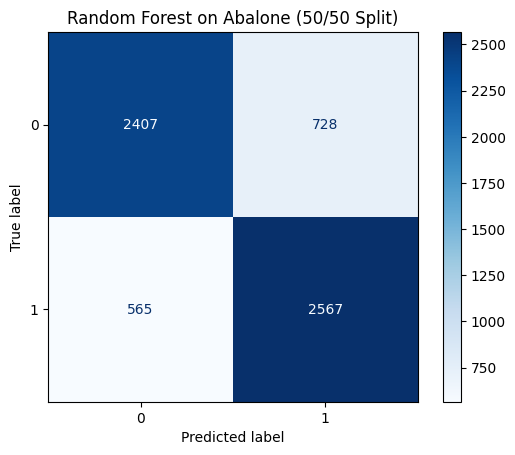

Results for Random Forest on Abalone (20/80 Split):
  Average Train Accuracy: 0.9533
  Average Train Error: 0.0467
  Average Validation Accuracy: 0.7920
  Average Validation Error: 0.2080
  Average Test Accuracy: 0.7808
  Average Test Error: 0.2192
  Test Precision: 0.7869
  Test Recall: 0.7603
  Test Precision: 0.7618
  Test Recall: 0.8136
  Test Precision: 0.7524
  Test Recall: 0.8385
  Average Test Precision: 0.7671
  Average Test Recall: 0.8041


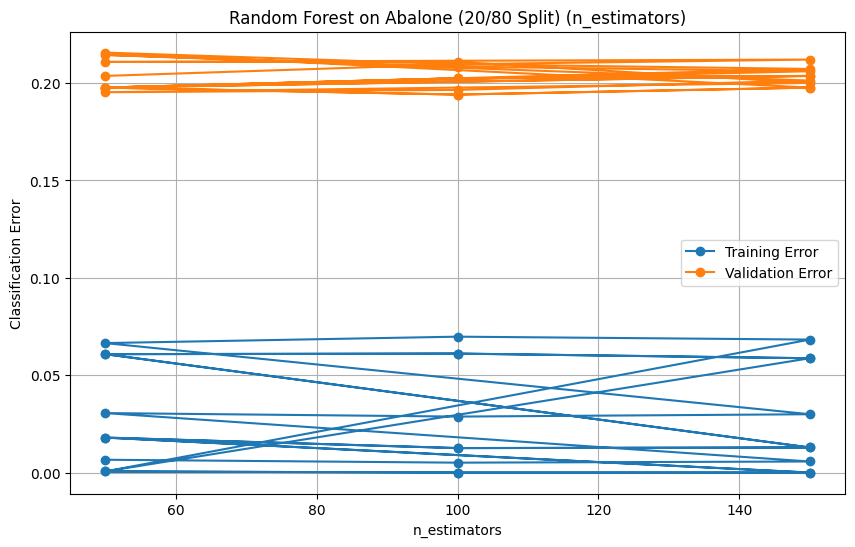

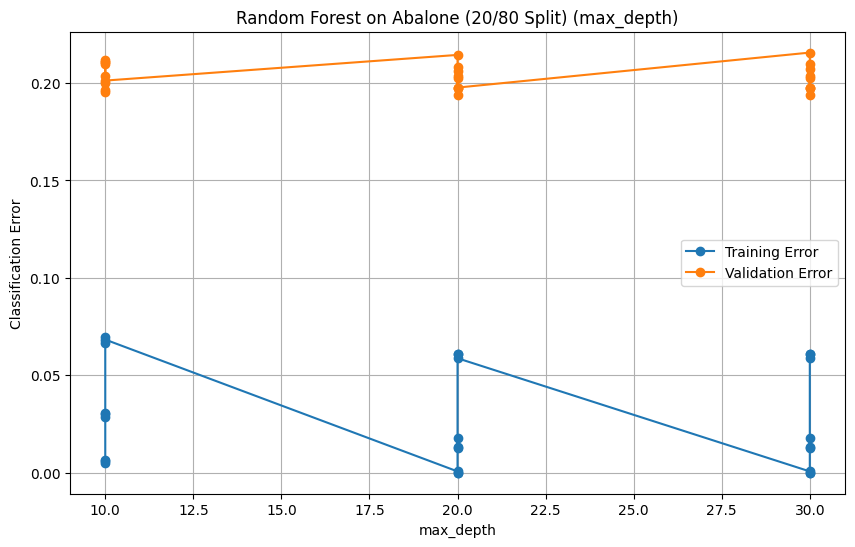

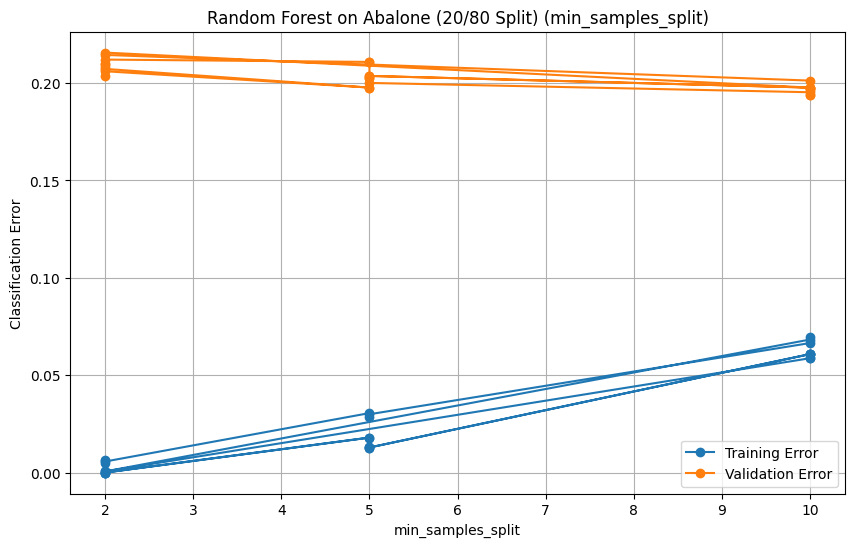

  Aggregated Confusion Matrix:
[[3824 1221]
 [ 977 4004]]



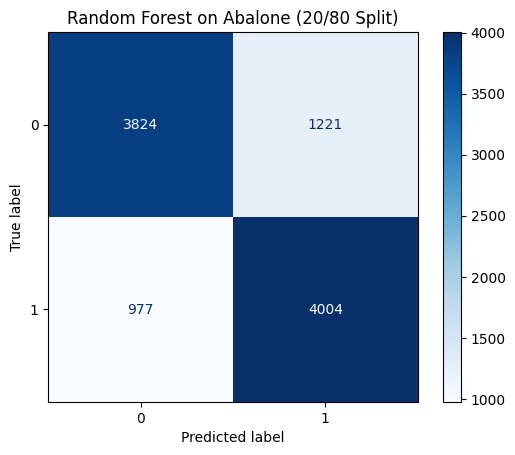

Best Validation Accuracy for Random Forest on Abalone dataset: 0.7983 (Partition: 80/19)

Best Test Accuracy for Random Forest on Abalone dataset: 0.8026

Best Train Accuracy for Random Forest on Abalone dataset: 0.9533



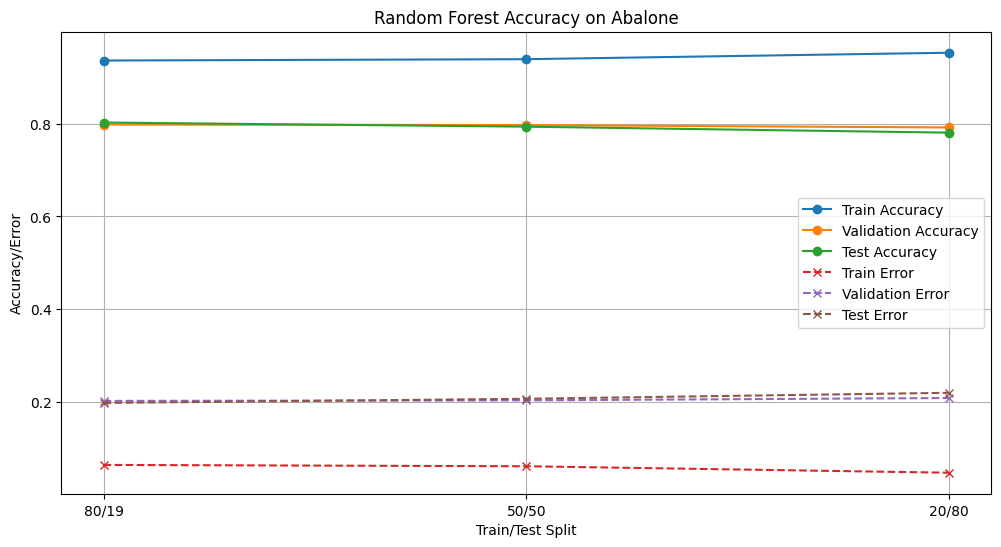

In [8]:
print("\n========== Running Models on Abalone Dataset ==========")
X_abalone, y_abalone = preprocess_abalone(abalone_file)
X_abalone = scale_data(X_abalone)
abalone_results = []  
for clf_name, (clf, param_grid) in classifiers.items():
    print(f"\nRunning {clf_name} on Abalone dataset...\n")
    results = train_and_evaluate_with_confusion(clf, param_grid, X_abalone, y_abalone, partitions=partitions)

    best_score = 0 
    best_partition = None  
    best_test_score = 0  
    best_train_score = 0  

    for partition, result in results.items():
        print(f"Results for {clf_name} on Abalone ({partition} Split):")
        print(f"  Average Train Accuracy: {result['average_train_accuracy']:.4f}")
        print(f"  Average Train Error: {1 - result['average_train_accuracy']:.4f}")
        print(f"  Average Validation Accuracy: {result['average_validation_accuracy']:.4f}")
        print(f"  Average Validation Error: {1 - result['average_validation_accuracy']:.4f}")
        print(f"  Average Test Accuracy: {result['average_test_accuracy']:.4f}")
        print(f"  Average Test Error: {1 - result['average_test_accuracy']:.4f}")

        for trial in result['all_trials']:
            print(f"  Test Precision: {trial['test_precision']:.4f}")
            print(f"  Test Recall: {trial['test_recall']:.4f}")

        avg_precision = np.mean([trial['test_precision'] for trial in result['all_trials']])
        avg_recall = np.mean([trial['test_recall'] for trial in result['all_trials']])
        print(f"  Average Test Precision: {avg_precision:.4f}")
        print(f"  Average Test Recall: {avg_recall:.4f}")


        if result['average_validation_accuracy'] > best_score:
            best_score = result['average_validation_accuracy']
            best_partition = partition

        if result['average_test_accuracy'] > best_test_score:
            best_test_score = result['average_test_accuracy']

        if result['average_train_accuracy'] > best_train_score:
            best_train_score = result['average_train_accuracy']

        trial = result['all_trials'][0]
        for hyperparam in param_grid.keys():
            plot_error_curves(trial['cv_results'], hyperparam, f"{clf_name} on Abalone ({partition} Split)")

        aggregated_confusion = sum(np.array(t['confusion_matrix']) for t in result['all_trials'])
        print(f"  Aggregated Confusion Matrix:\n{aggregated_confusion}\n")
        plot_confusion_matrix(aggregated_confusion, f"{clf_name} on Abalone ({partition} Split)")

    print(f"Best Validation Accuracy for {clf_name} on Abalone dataset: {best_score:.4f} (Partition: {best_partition})\n")
    print(f"Best Test Accuracy for {clf_name} on Abalone dataset: {best_test_score:.4f}\n")
    print(f"Best Train Accuracy for {clf_name} on Abalone dataset: {best_train_score:.4f}\n")
    plot_results(results, f"{clf_name} Accuracy on Abalone")

    abalone_results.append((clf_name, best_partition, best_score, best_test_score, best_train_score))


========== Running Models on Student Dataset ==========

Running Decision Tree on Student dataset...

Results for Decision Tree on Student (80/19 Split):
  Average Train Accuracy: 0.9694
  Average Train Error: 0.0306
  Average Validation Accuracy: 0.8828
  Average Validation Error: 0.1172
  Average Test Accuracy: 0.8945
  Average Test Error: 0.1055
  Test Precision: 0.9286
  Test Recall: 0.8966
  Test Precision: 0.9649
  Test Recall: 0.9322
  Test Precision: 0.9138
  Test Recall: 0.9298
  Average Test Precision: 0.9358
  Average Test Recall: 0.9195


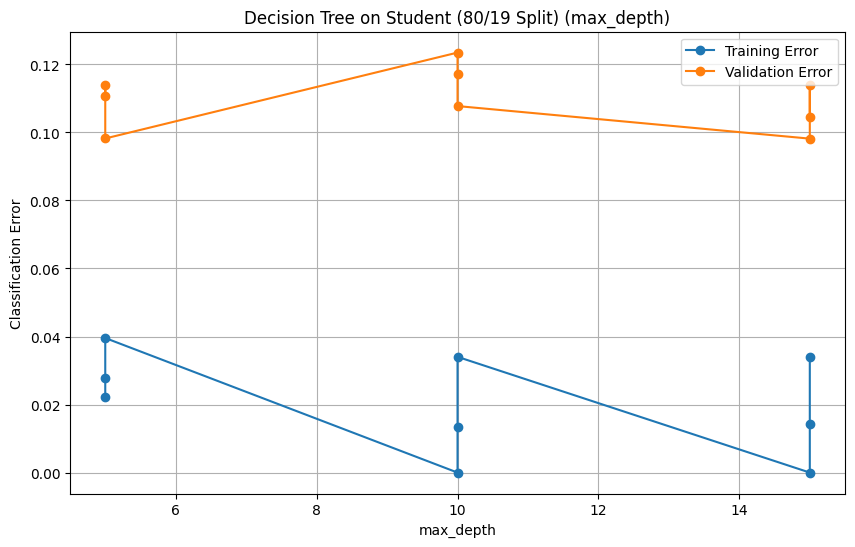

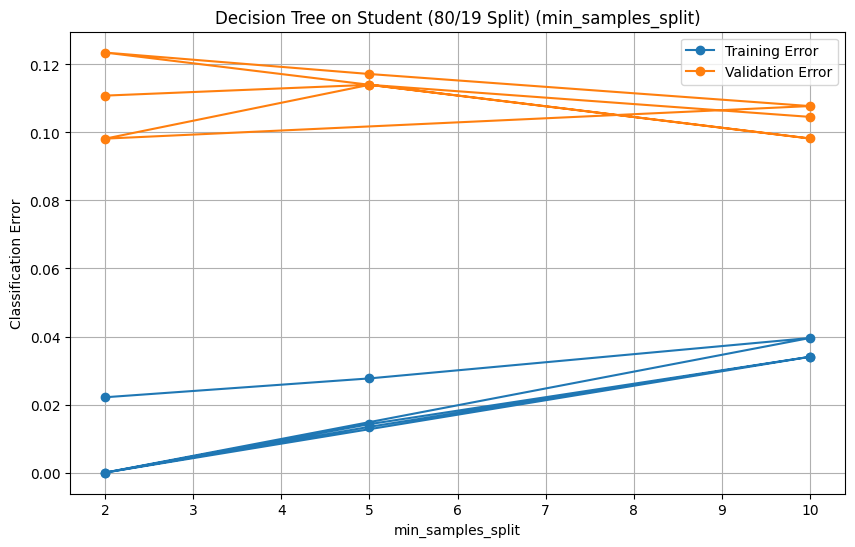

  Aggregated Confusion Matrix:
[[ 52  11]
 [ 14 160]]



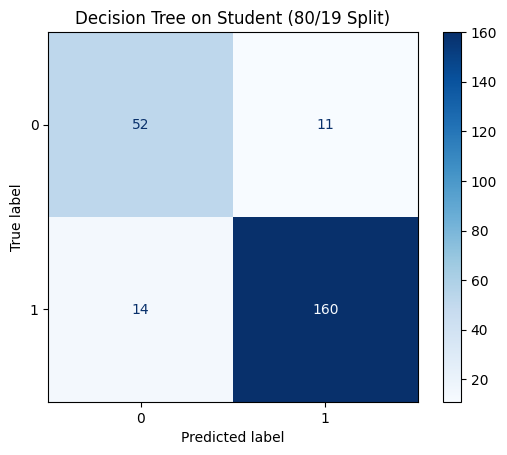

Results for Decision Tree on Student (50/50 Split):
  Average Train Accuracy: 0.9712
  Average Train Error: 0.0288
  Average Validation Accuracy: 0.8882
  Average Validation Error: 0.1118
  Average Test Accuracy: 0.8771
  Average Test Error: 0.1229
  Test Precision: 0.9124
  Test Recall: 0.8993
  Test Precision: 0.8889
  Test Recall: 0.9552
  Test Precision: 0.9084
  Test Recall: 0.9015
  Average Test Precision: 0.9032
  Average Test Recall: 0.9187


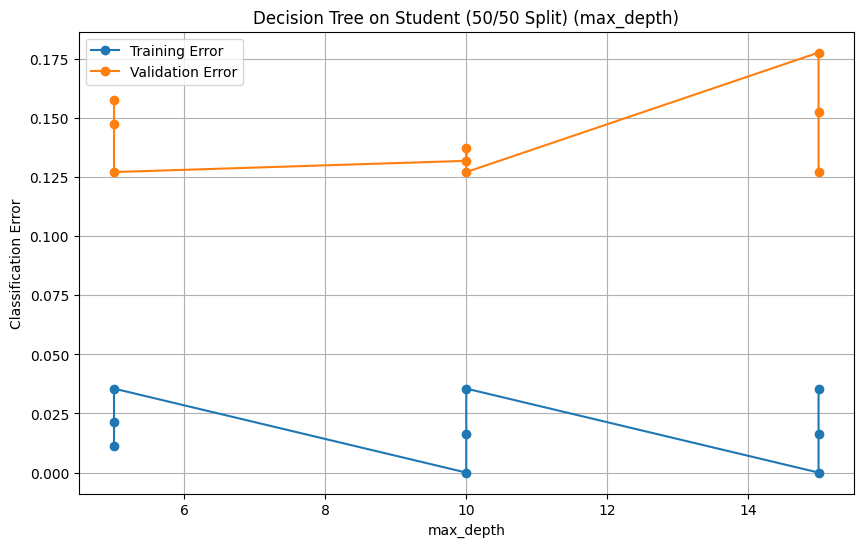

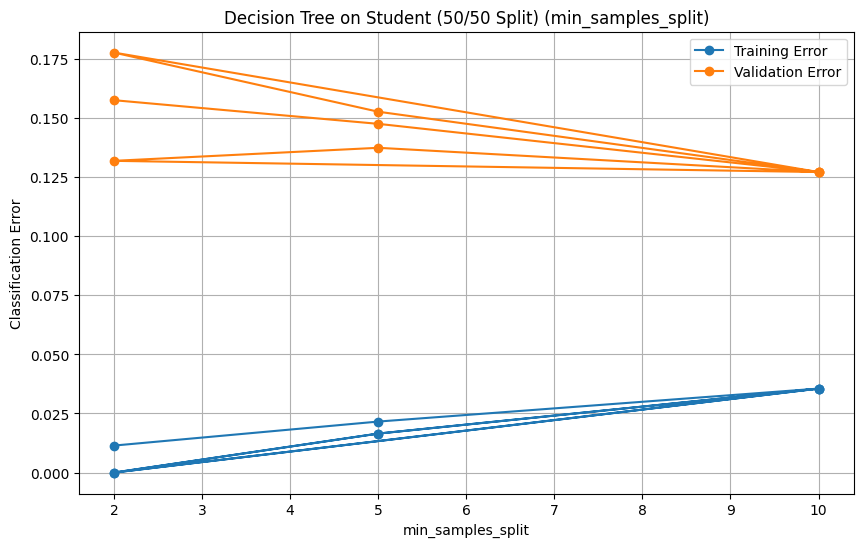

  Aggregated Confusion Matrix:
[[149  40]
 [ 33 372]]



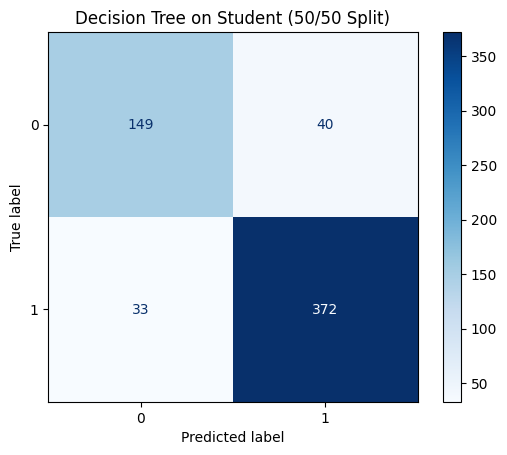

Results for Decision Tree on Student (20/80 Split):
  Average Train Accuracy: 0.9536
  Average Train Error: 0.0464
  Average Validation Accuracy: 0.8778
  Average Validation Error: 0.1222
  Average Test Accuracy: 0.8935
  Average Test Error: 0.1065
  Test Precision: 0.9447
  Test Recall: 0.8744
  Test Precision: 0.9659
  Test Recall: 0.9000
  Test Precision: 0.8856
  Test Recall: 0.9676
  Average Test Precision: 0.9321
  Average Test Recall: 0.9140


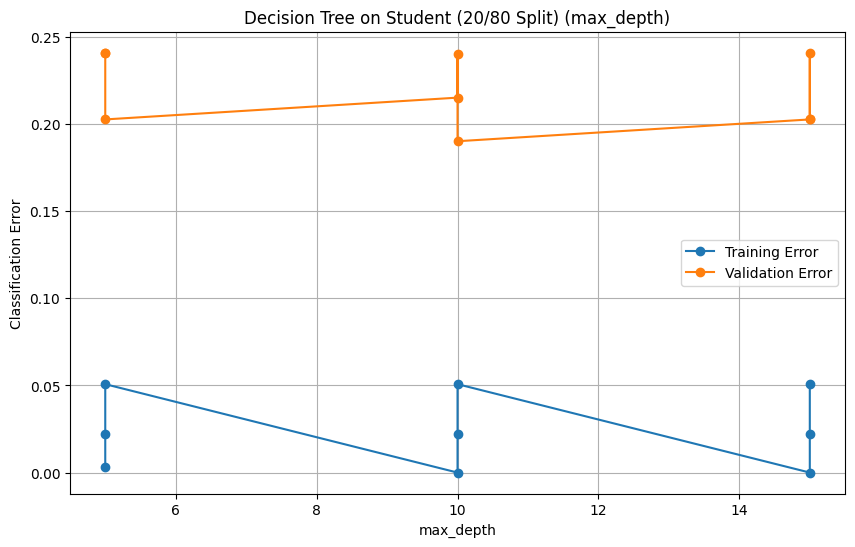

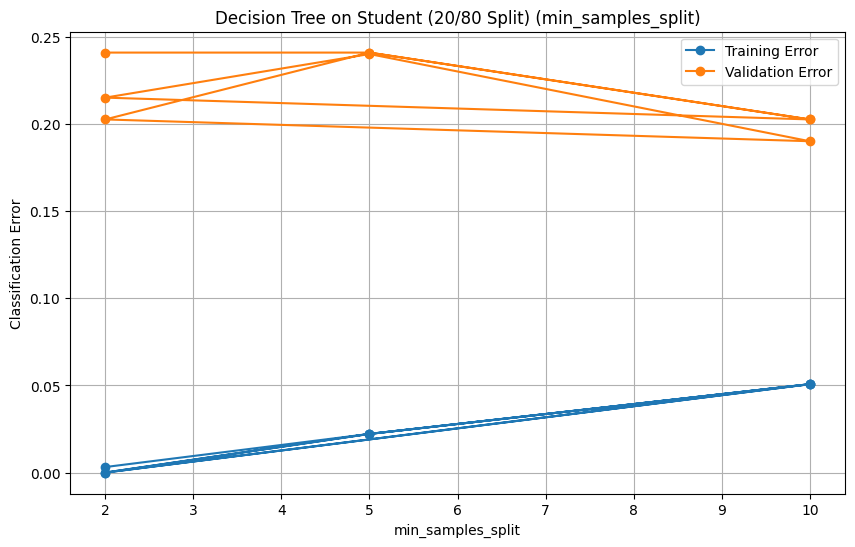

  Aggregated Confusion Matrix:
[[252  45]
 [ 56 595]]



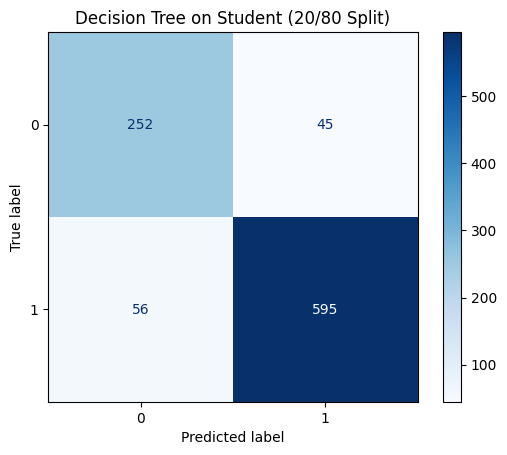

Best Validation Accuracy for Decision Tree on Student dataset: 0.8882 (Partition: 50/50)

Best Test Accuracy for Decision Tree on Student dataset: 0.8945

Best Train Accuracy for Decision Tree on Student dataset: 0.9712



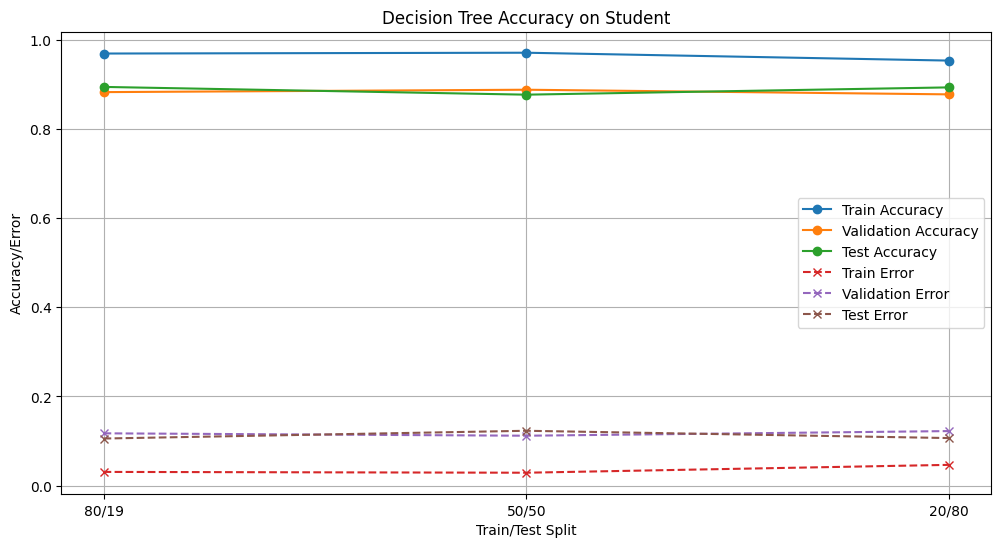


Running KNN on Student dataset...



/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Results for KNN on Student (80/19 Split):
  Average Train Accuracy: 0.8196
  Average Train Error: 0.1804
  Average Validation Accuracy: 0.7804
  Average Validation Error: 0.2196
  Average Test Accuracy: 0.7426
  Average Test Error: 0.2574
  Test Precision: 0.6528
  Test Recall: 0.9792
  Test Precision: 0.7313
  Test Recall: 0.9800
  Test Precision: 0.8182
  Test Recall: 0.9310
  Average Test Precision: 0.7341
  Average Test Recall: 0.9634


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


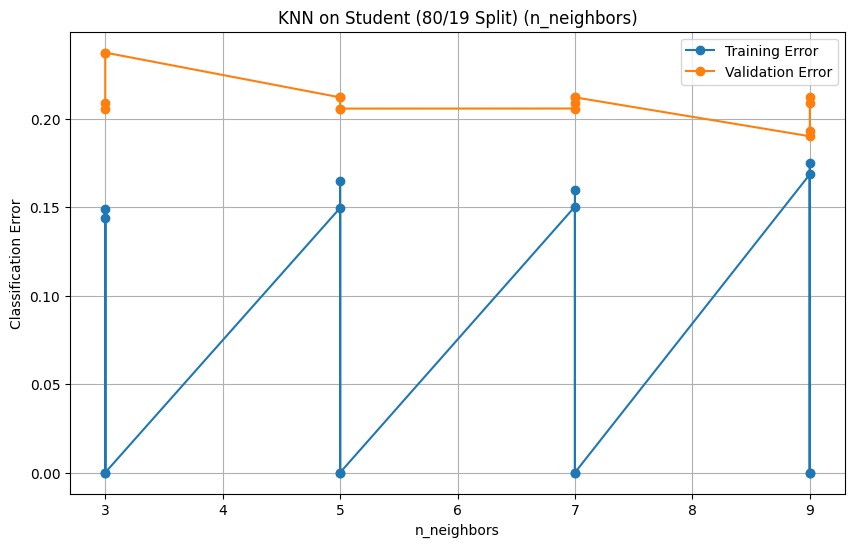

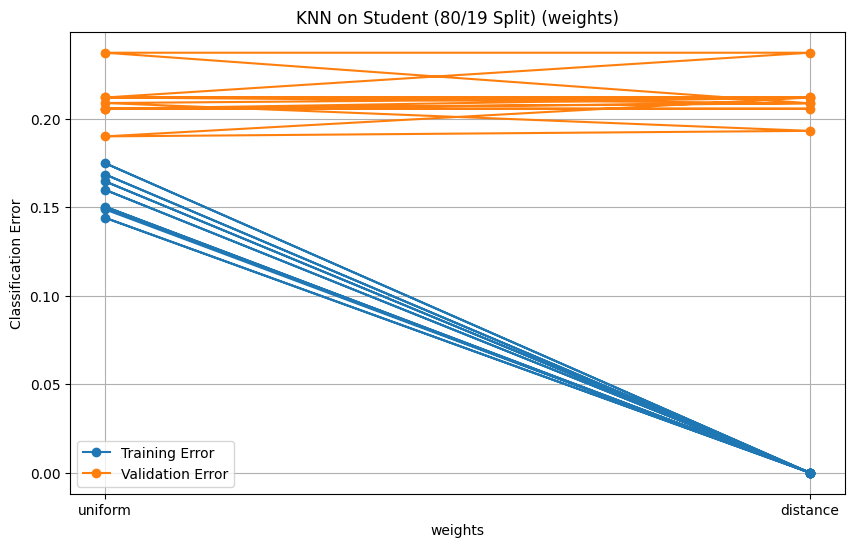

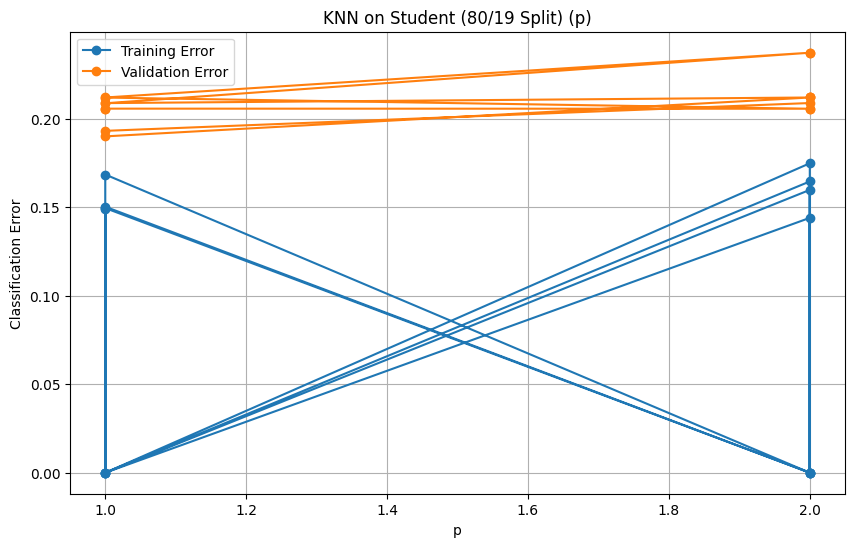

  Aggregated Confusion Matrix:
[[ 26  55]
 [  6 150]]



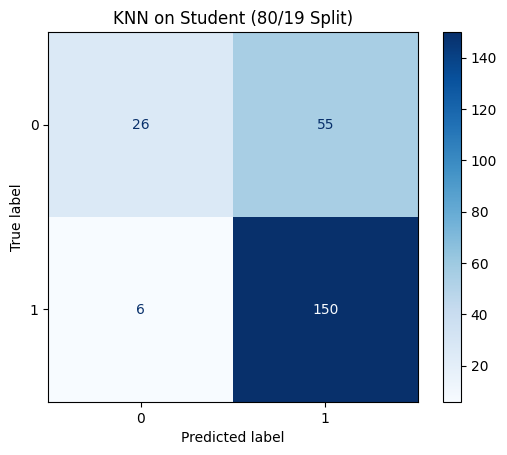

Results for KNN on Student (50/50 Split):
  Average Train Accuracy: 0.8477
  Average Train Error: 0.1523
  Average Validation Accuracy: 0.7445
  Average Validation Error: 0.2555
  Average Test Accuracy: 0.7525
  Average Test Error: 0.2475
  Test Precision: 0.7817
  Test Recall: 0.8284
  Test Precision: 0.8456
  Test Recall: 0.8571
  Test Precision: 0.7622
  Test Recall: 0.9259
  Average Test Precision: 0.7965
  Average Test Recall: 0.8705


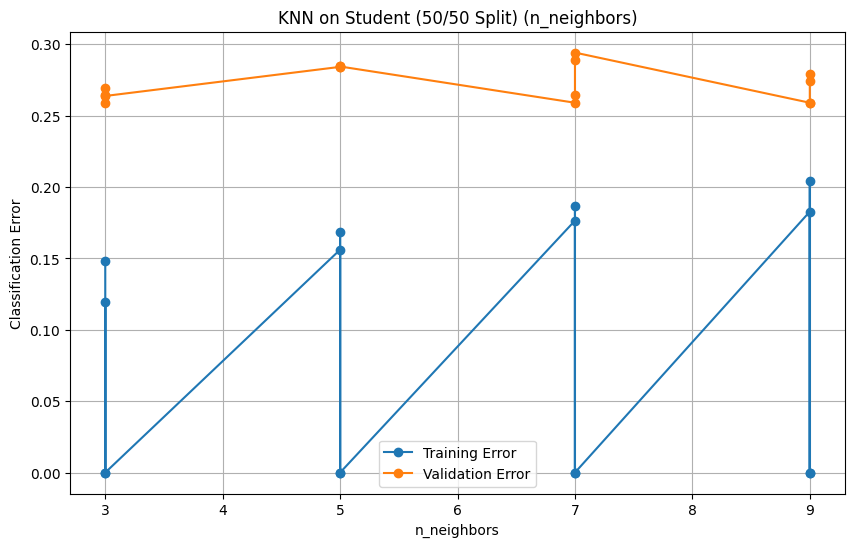

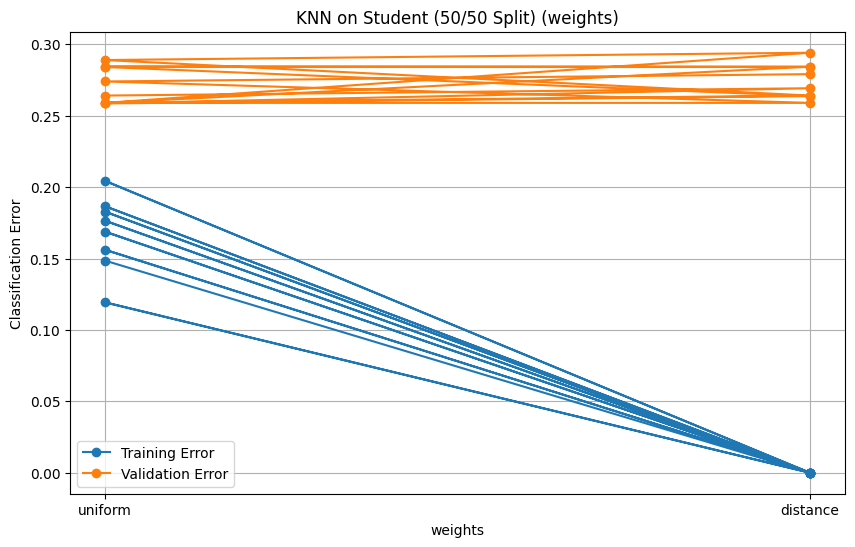

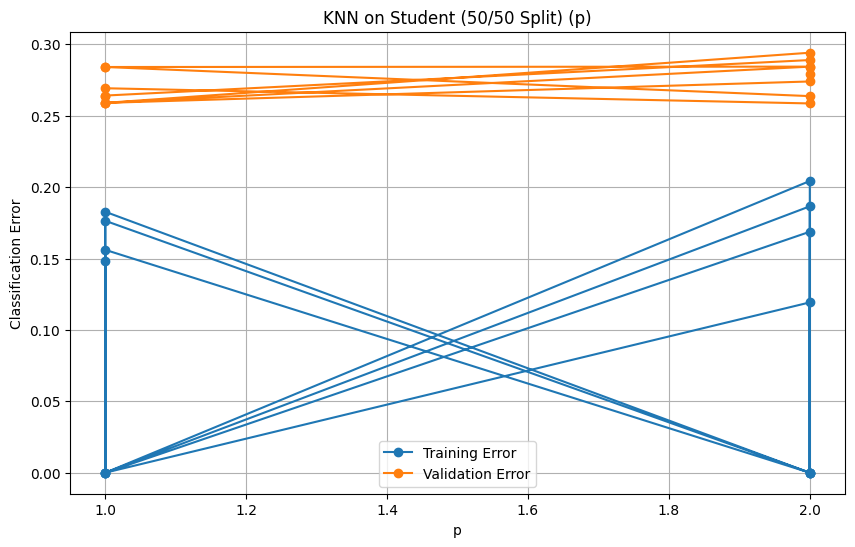

  Aggregated Confusion Matrix:
[[ 85  93]
 [ 54 362]]



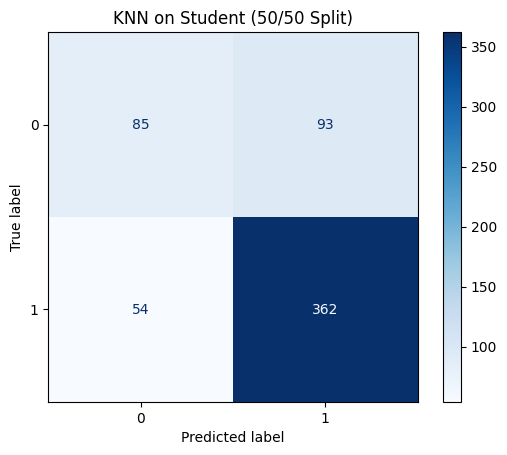

Results for KNN on Student (20/80 Split):
  Average Train Accuracy: 0.8439
  Average Train Error: 0.1561
  Average Validation Accuracy: 0.7806
  Average Validation Error: 0.2194
  Average Test Accuracy: 0.6930
  Average Test Error: 0.3070
  Test Precision: 0.6957
  Test Recall: 0.9275
  Test Precision: 0.6934
  Test Recall: 0.9707
  Test Precision: 0.7241
  Test Recall: 0.8791
  Average Test Precision: 0.7044
  Average Test Recall: 0.9258


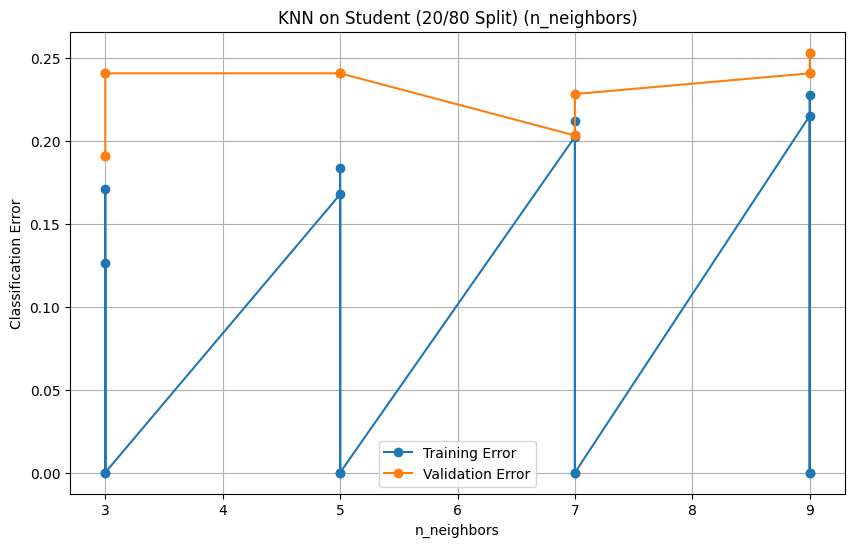

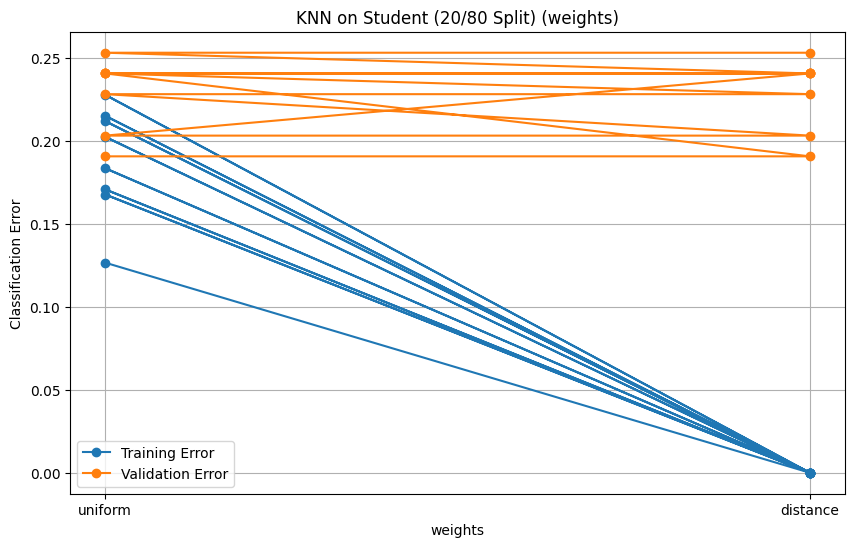

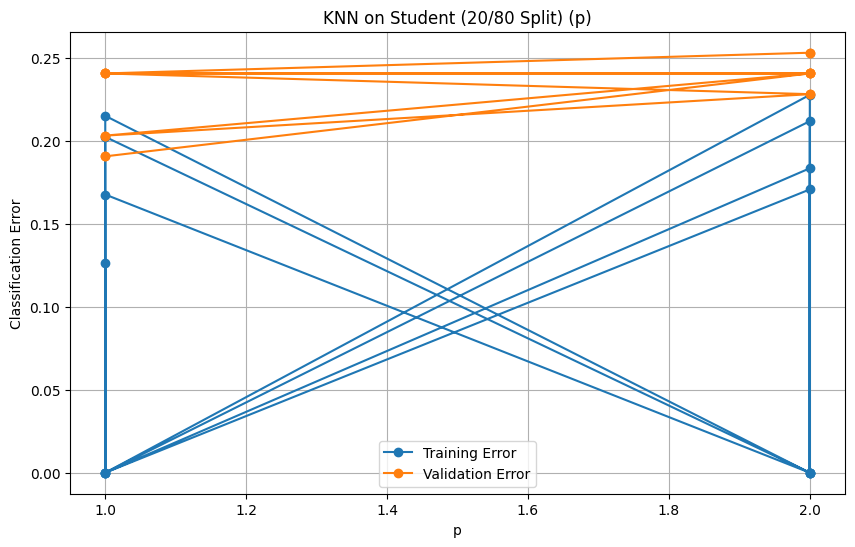

  Aggregated Confusion Matrix:
[[ 77 244]
 [ 47 580]]



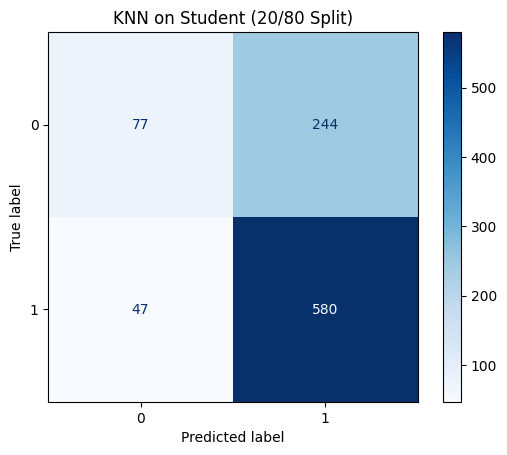

Best Validation Accuracy for KNN on Student dataset: 0.7806 (Partition: 20/80)

Best Test Accuracy for KNN on Student dataset: 0.7525

Best Train Accuracy for KNN on Student dataset: 0.8477



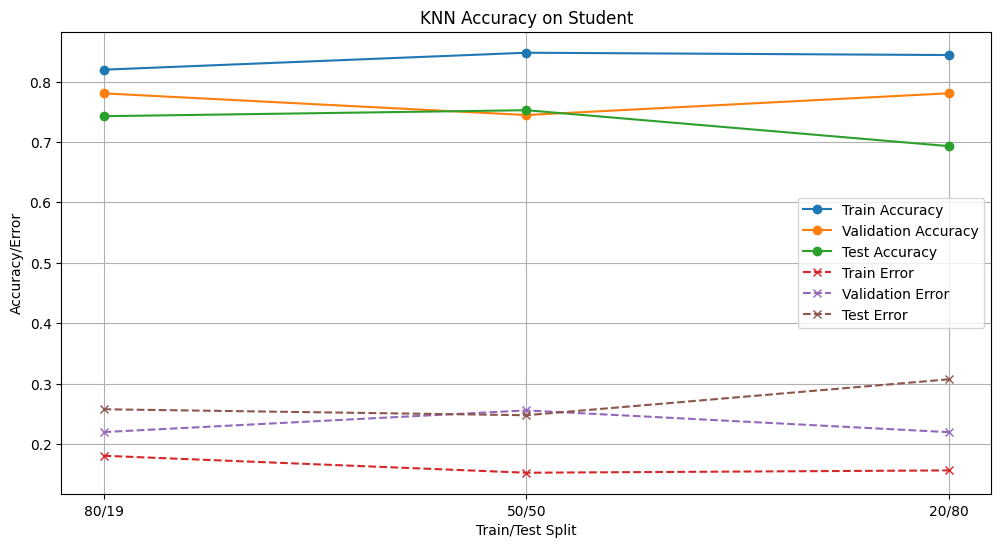


Running Random Forest on Student dataset...



/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Results for Random Forest on Student (80/19 Split):
  Average Train Accuracy: 0.9884
  Average Train Error: 0.0116
  Average Validation Accuracy: 0.9261
  Average Validation Error: 0.0739
  Average Test Accuracy: 0.8861
  Average Test Error: 0.1139
  Test Precision: 0.9583
  Test Recall: 0.9200
  Test Precision: 0.9216
  Test Recall: 0.8246
  Test Precision: 0.9583
  Test Recall: 0.9020
  Average Test Precision: 0.9461
  Average Test Recall: 0.8822


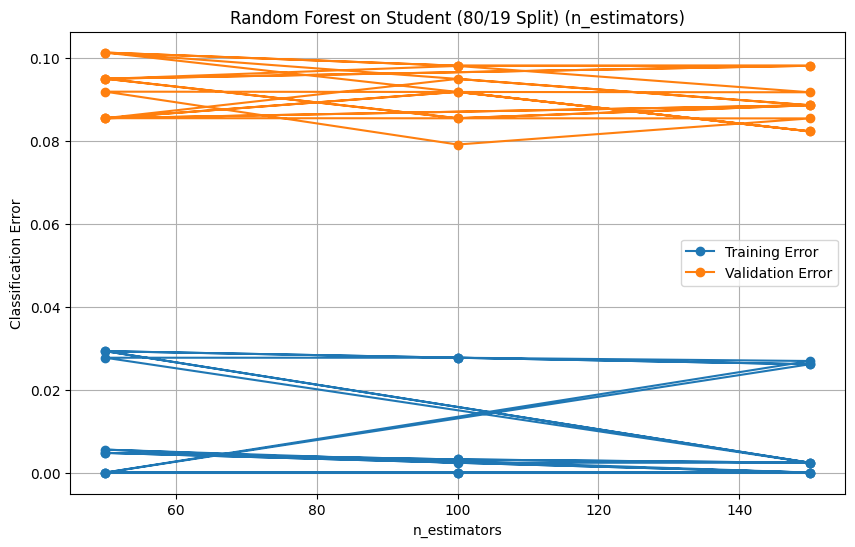

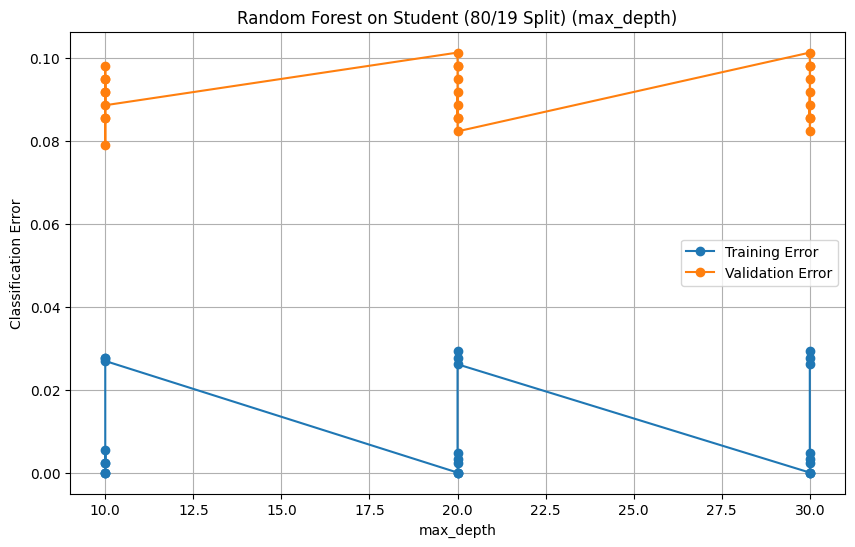

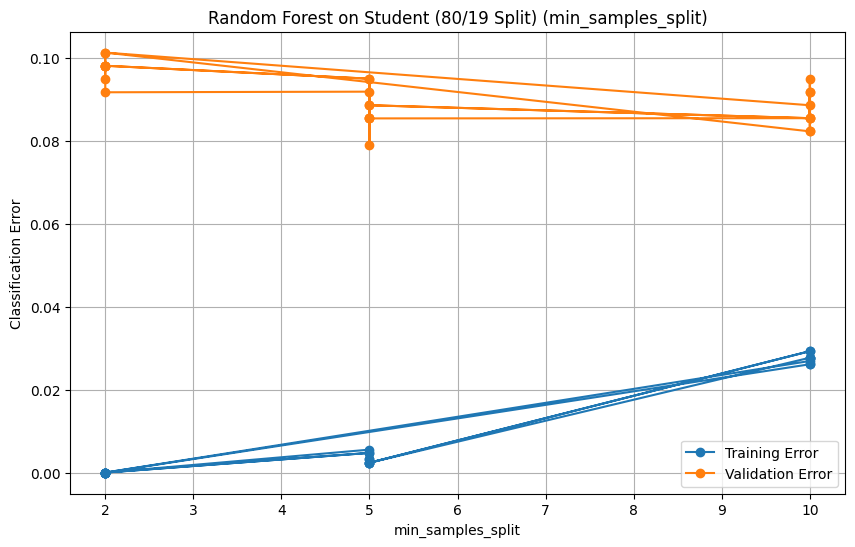

  Aggregated Confusion Matrix:
[[ 71   8]
 [ 19 139]]



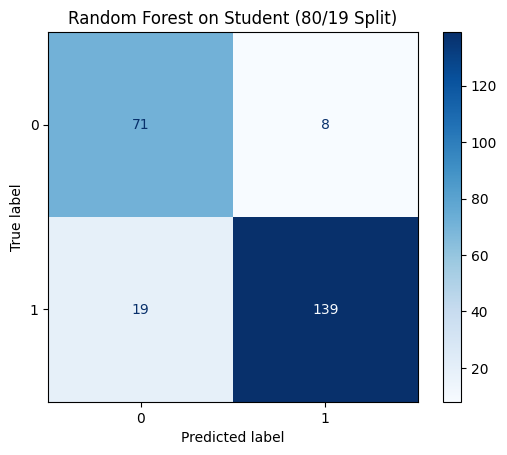

Results for Random Forest on Student (50/50 Split):
  Average Train Accuracy: 0.9729
  Average Train Error: 0.0271
  Average Validation Accuracy: 0.9086
  Average Validation Error: 0.0914
  Average Test Accuracy: 0.9007
  Average Test Error: 0.0993
  Test Precision: 0.9197
  Test Recall: 0.9265
  Test Precision: 0.9559
  Test Recall: 0.9220
  Test Precision: 0.9237
  Test Recall: 0.9167
  Average Test Precision: 0.9331
  Average Test Recall: 0.9217


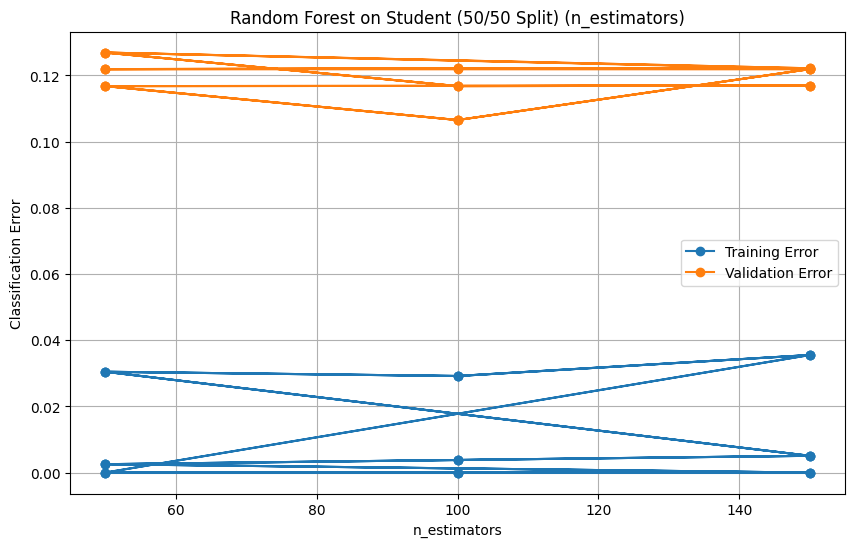

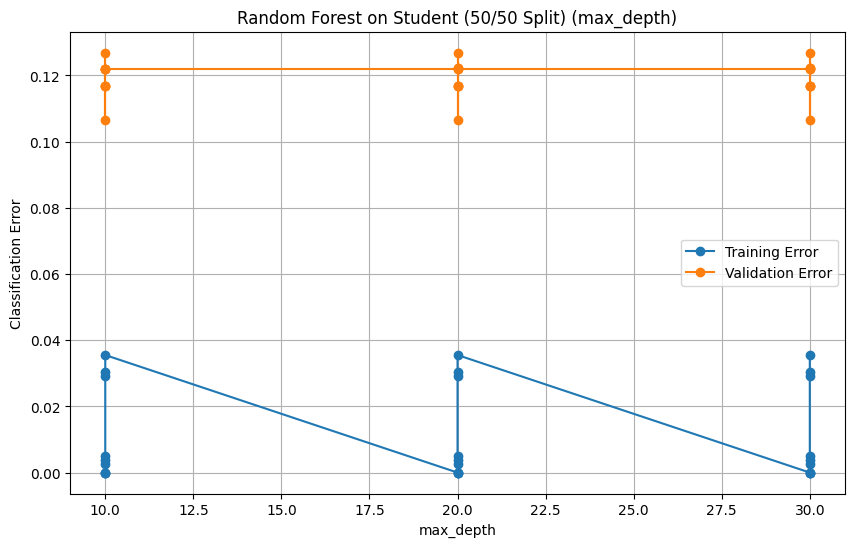

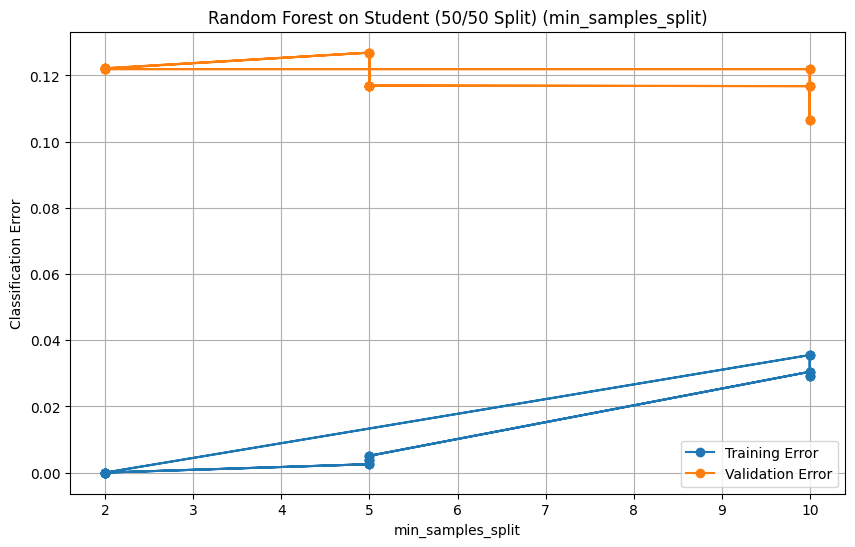

  Aggregated Confusion Matrix:
[[158  27]
 [ 32 377]]



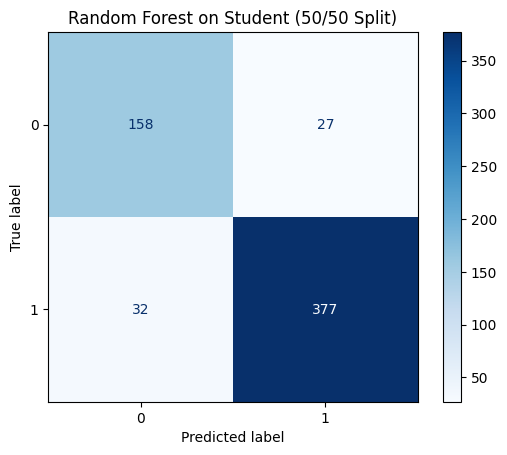

Results for Random Forest on Student (20/80 Split):
  Average Train Accuracy: 0.9958
  Average Train Error: 0.0042
  Average Validation Accuracy: 0.8894
  Average Validation Error: 0.1106
  Average Test Accuracy: 0.8660
  Average Test Error: 0.1340
  Test Precision: 0.9171
  Test Recall: 0.9213
  Test Precision: 0.9330
  Test Recall: 0.9028
  Test Precision: 0.7871
  Test Recall: 0.9952
  Average Test Precision: 0.8790
  Average Test Recall: 0.9398


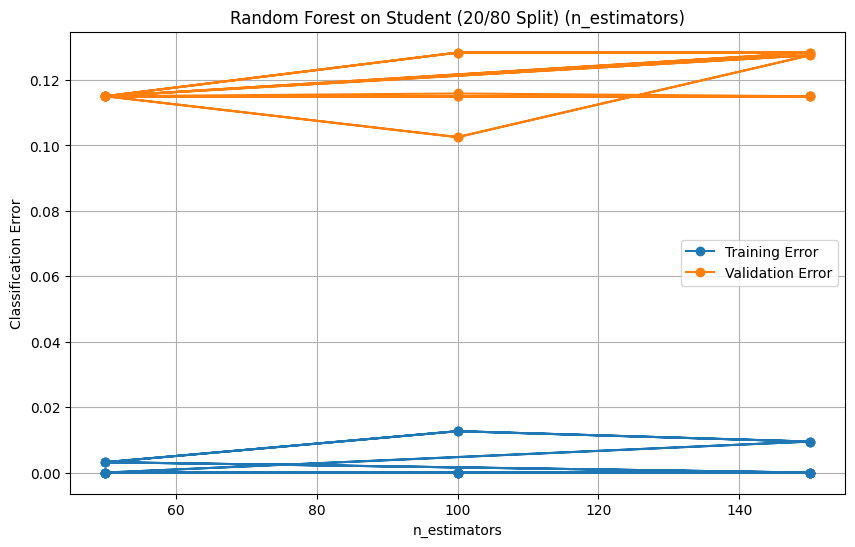

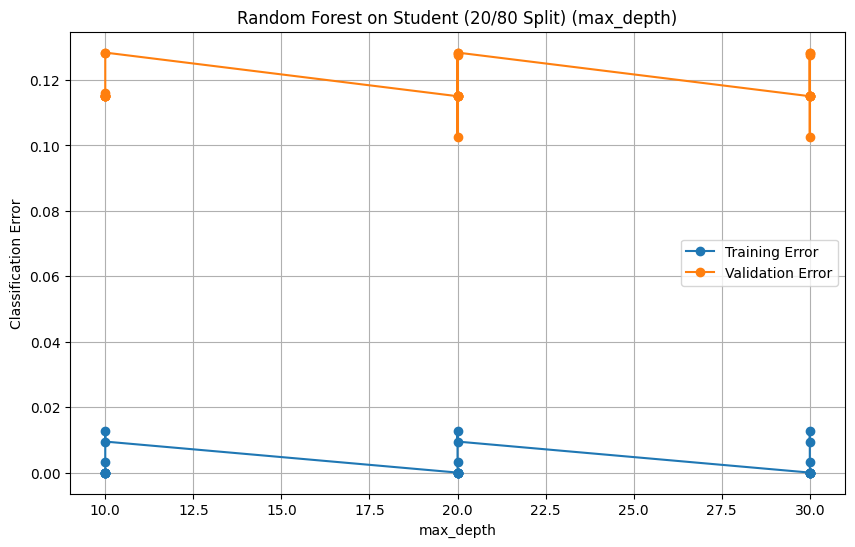

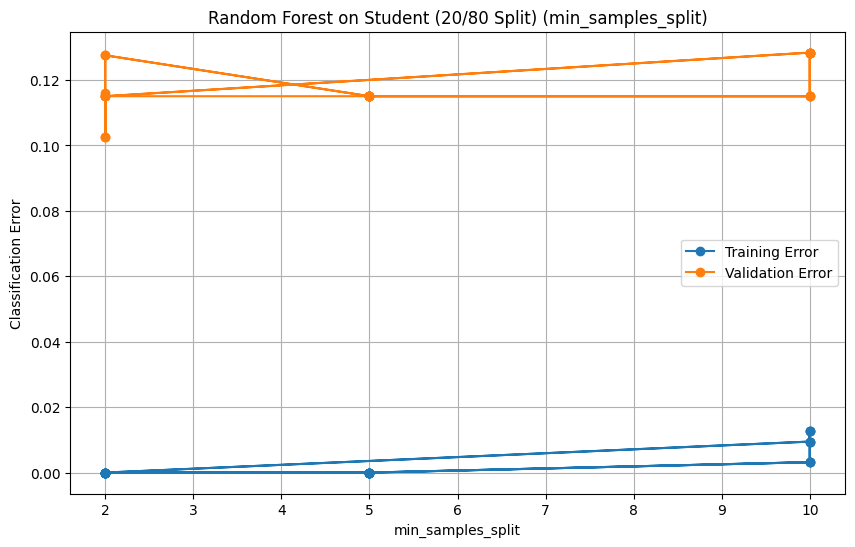

  Aggregated Confusion Matrix:
[[220  88]
 [ 39 601]]



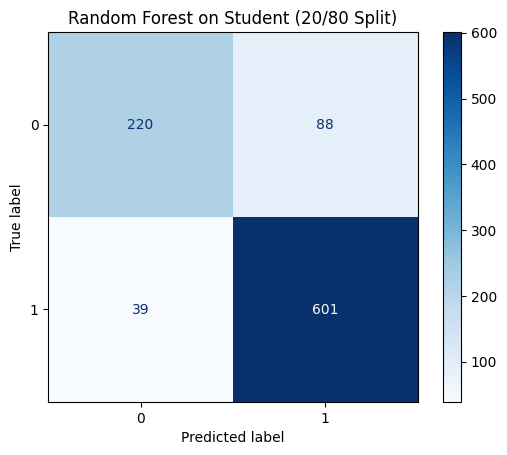

Best Validation Accuracy for Random Forest on Student dataset: 0.9261 (Partition: 80/19)

Best Test Accuracy for Random Forest on Student dataset: 0.9007

Best Train Accuracy for Random Forest on Student dataset: 0.9958



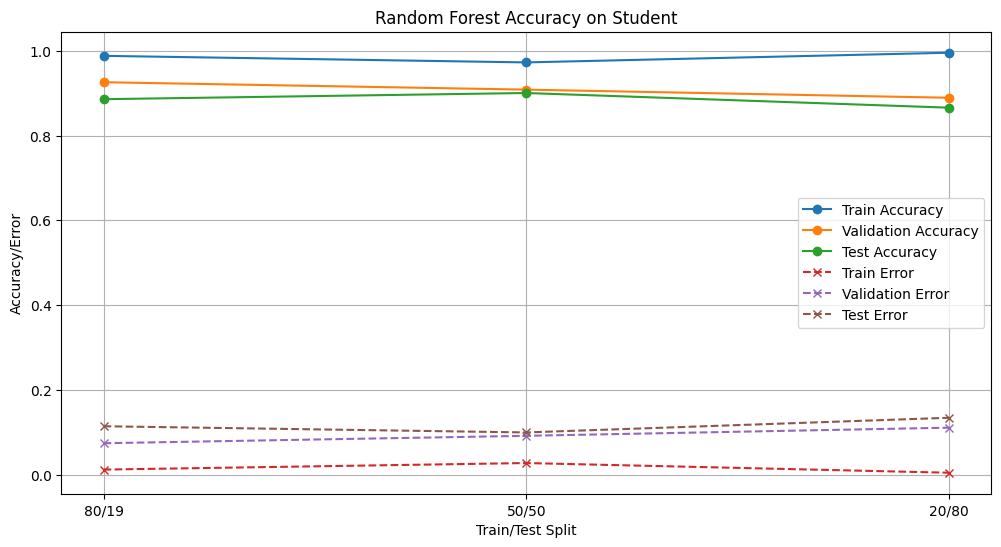

In [9]:
print("\n========== Running Models on Student Dataset ==========")
X_student, y_student = preprocess_student(student_file)
X_student = scale_data(X_student)
student_results = []  
for clf_name, (clf, param_grid) in classifiers.items():
    print(f"\nRunning {clf_name} on Student dataset...\n")
    results = train_and_evaluate_with_confusion(clf, param_grid, X_student, y_student, partitions=partitions)

    best_score = 0  
    best_partition = None  
    best_test_score = 0  
    best_train_score = 0  

    for partition, result in results.items():
        print(f"Results for {clf_name} on Student ({partition} Split):")
        print(f"  Average Train Accuracy: {result['average_train_accuracy']:.4f}")
        print(f"  Average Train Error: {1 - result['average_train_accuracy']:.4f}")
        print(f"  Average Validation Accuracy: {result['average_validation_accuracy']:.4f}")
        print(f"  Average Validation Error: {1 - result['average_validation_accuracy']:.4f}")
        print(f"  Average Test Accuracy: {result['average_test_accuracy']:.4f}")
        print(f"  Average Test Error: {1 - result['average_test_accuracy']:.4f}")

        for trial in result['all_trials']:
            print(f"  Test Precision: {trial['test_precision']:.4f}")
            print(f"  Test Recall: {trial['test_recall']:.4f}")

        avg_precision = np.mean([trial['test_precision'] for trial in result['all_trials']])
        avg_recall = np.mean([trial['test_recall'] for trial in result['all_trials']])
        print(f"  Average Test Precision: {avg_precision:.4f}")
        print(f"  Average Test Recall: {avg_recall:.4f}")


        if result['average_validation_accuracy'] > best_score:
            best_score = result['average_validation_accuracy']
            best_partition = partition

        if result['average_test_accuracy'] > best_test_score:
            best_test_score = result['average_test_accuracy']

        if result['average_train_accuracy'] > best_train_score:
            best_train_score = result['average_train_accuracy']

        trial = result['all_trials'][0]
        for hyperparam in param_grid.keys():
            plot_error_curves(trial['cv_results'], hyperparam, f"{clf_name} on Student ({partition} Split)")

        aggregated_confusion = sum(np.array(t['confusion_matrix']) for t in result['all_trials'])
        print(f"  Aggregated Confusion Matrix:\n{aggregated_confusion}\n")
        plot_confusion_matrix(aggregated_confusion, f"{clf_name} on Student ({partition} Split)")

    print(f"Best Validation Accuracy for {clf_name} on Student dataset: {best_score:.4f} (Partition: {best_partition})\n")
    print(f"Best Test Accuracy for {clf_name} on Student dataset: {best_test_score:.4f}\n")
    print(f"Best Train Accuracy for {clf_name} on Student dataset: {best_train_score:.4f}\n")
    plot_results(results, f"{clf_name} Accuracy on Student")

    student_results.append((clf_name, best_partition, best_score, best_test_score, best_train_score))

In [10]:
print("\n========== Final Report ==========")
print("\nBest Classifier and Partition for Each Dataset:")

def report_best(results, dataset_name):
    best_model = max(results, key=lambda x: x[2])  
    print(f"{dataset_name}:\n")
    print(f"  Best Classifier: {best_model[0]}")
    print(f"  Best Partition: {best_model[1]}")
    print(f"  Best Validation Accuracy: {best_model[2]:.4f}")
    print(f"  Best Test Accuracy: {best_model[3]:.4f}")
    print(f"  Best Train Accuracy: {best_model[4]:.4f}\n")

report_best(wine_results, "Wine Dataset")
report_best(abalone_results, "Abalone Dataset")
report_best(student_results, "Student Dataset")



========== Final Report ==========

Best Classifier and Partition for Each Dataset:
Wine Dataset:

  Best Classifier: Random Forest
  Best Partition: 80/19
  Best Validation Accuracy: 0.8732
  Best Test Accuracy: 0.8718
  Best Train Accuracy: 0.9986

Abalone Dataset:

  Best Classifier: Random Forest
  Best Partition: 80/19
  Best Validation Accuracy: 0.7983
  Best Test Accuracy: 0.8026
  Best Train Accuracy: 0.9533

Student Dataset:

  Best Classifier: Random Forest
  Best Partition: 80/19
  Best Validation Accuracy: 0.9261
  Best Test Accuracy: 0.9007
  Best Train Accuracy: 0.9958



In [11]:
import pandas as pd

def aggregate_results(results, dataset_name):
    formatted_data = {}
    for clf_name, partition, val_acc, test_acc, train_acc in results:
        if clf_name not in formatted_data:
            formatted_data[clf_name] = {}
        formatted_data[clf_name][dataset_name] = f"{test_acc:.3f}/{val_acc:.3f}/{train_acc:.3f}"
    return formatted_data

wine_aggregated = aggregate_results(wine_results, "Wine")
abalone_aggregated = aggregate_results(abalone_results, "Abalone")
student_aggregated = aggregate_results(student_results, "Student")

all_results = {}
for algo in set(wine_aggregated.keys()).union(abalone_aggregated.keys(), student_aggregated.keys()):
    all_results[algo] = {
        "Wine": wine_aggregated.get(algo, {}).get("Wine", "N/A"),
        "Abalone": abalone_aggregated.get(algo, {}).get("Abalone", "N/A"),
        "Student": student_aggregated.get(algo, {}).get("Student", "N/A")
    }

final_table = pd.DataFrame.from_dict(all_results, orient="index")
final_table.index.name = "Algo\\Dataset"
final_table.reset_index(inplace=True)

print("Table 1: Test/Validation/Training Accuracy for all splits")
print(final_table)



Table 1: Test/Validation/Training Accuracy for all splits
    Algo\Dataset               Wine            Abalone            Student
0  Decision Tree  0.825/0.813/0.975  0.768/0.782/0.865  0.895/0.888/0.971
1            KNN  0.873/0.864/1.000  0.790/0.791/0.938  0.753/0.781/0.848
2  Random Forest  0.872/0.873/0.999  0.803/0.798/0.953  0.901/0.926/0.996
